# Forecasting Weekly Hydro Energy Generation in New Zealand
Model - SARIMA

This notebook addresses:
* RQ1: How well does a SARIMA model forecast weekly hydro energy generation?
* RQ2: Does incorporating weekly-aggregated climate variables into SARIMAX improve forecasting accuracy?

The analysis uses weekly sumed and weekly averaged NASA climate data, aligned with operational hydro generation data.

In [2]:
# Import libraries for sarima model and visuals
import pandas as pd
import numpy as np
import seaborn as sns
import pmdarima as pm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error , root_mean_squared_error , mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.losses import Huber
import random


# Hydro - EDA

In [4]:
# Step 1 : Loading previously processed hydro energy generation and climate factors
hydro_energy = pd.read_csv('hydro_data.csv')
daily_all_nsp_evland = pd.read_csv('Hydro_Factor_Daily_EVLAND.csv')
daily_all_nsp_gwetprof = pd.read_csv('Hydro_Factor_Daily_GWETPROF.csv')
daily_all_nsp_prectotcorr = pd.read_csv('Hydro_Factor_Daily_PRECTOTCORR.csv')
daily_all_nsp_rh2m = pd.read_csv('Hydro_Factor_Daily_RH2M.csv')
daily_all_nsp_t2m = pd.read_csv('Hydro_Factor_Daily_T2M.csv')

In [5]:
hydro_energy.tail()

,Fuel_Code,POC_Code,DATE,Total_TP,Island,Latitude,Longitude
132197,Hydro,WTK0111,2025-01-27,1427007.0,SI,-44.692099,170.429029
132198,Hydro,WTK0111,2025-01-28,1990551.0,SI,-44.692099,170.429029
132199,Hydro,WTK0111,2025-01-29,1720931.0,SI,-44.692099,170.429029
132200,Hydro,WTK0111,2025-01-30,1407865.0,SI,-44.692099,170.429029
132201,Hydro,WTK0111,2025-01-31,1610301.0,SI,-44.692099,170.429029


In [6]:
daily_all_nsp_evland.head()

,DATE,POC_Code,EVLAND
0,2015-01-01,ARA2201,4.03
1,2015-01-02,ARA2201,1.94
2,2015-01-03,ARA2201,2.24
3,2015-01-04,ARA2201,1.54
4,2015-01-05,ARA2201,1.95


In [7]:
print("------------hydro_energy----------------------")
print(hydro_energy.head())
print("----------------------------------------------")
print(hydro_energy.dtypes)
print("----------------------------------------------")
print("------------daily_all_nsp_evland--------------")
print(daily_all_nsp_evland.head())
print("----------------------------------------------")
print(daily_all_nsp_evland.dtypes)
print("----------------------------------------------")
print("-------------daily_all_nsp_gwetprof-----------")
print(daily_all_nsp_gwetprof.head())
print("----------------------------------------------")
print(daily_all_nsp_gwetprof.dtypes)
print("----------------------------------------------")
print("-------------daily_all_nsp_prectotcorr--------")
print(daily_all_nsp_prectotcorr.head())
print("----------------------------------------------")
print(daily_all_nsp_prectotcorr.dtypes)
print("----------------------------------------------")
print("-------------daily_all_nsp_rh2m---------------")
print(daily_all_nsp_rh2m.head())
print("----------------------------------------------")
print(daily_all_nsp_rh2m.dtypes)
print("----------------------------------------------")
print("-------------daily_all_nsp_t2m----------------")
print(daily_all_nsp_t2m.head())
print("----------------------------------------------")
print(daily_all_nsp_t2m.dtypes)
print("----------------------------------------------")

------------hydro_energy----------------------
  Fuel_Code POC_Code        DATE  Total_TP Island   Latitude   Longitude
0     Hydro  ARA2201  2015-03-01  484010.0     NI -38.615891  176.143036
1     Hydro  ARA2201  2015-03-02  598280.0     NI -38.615891  176.143036
2     Hydro  ARA2201  2015-03-03  626290.0     NI -38.615891  176.143036
3     Hydro  ARA2201  2015-03-04  826700.0     NI -38.615891  176.143036
4     Hydro  ARA2201  2015-03-05  891070.0     NI -38.615891  176.143036
----------------------------------------------
Fuel_Code     object
POC_Code      object
DATE          object
Total_TP     float64
Island        object
Latitude     float64
Longitude    float64
dtype: object
----------------------------------------------
------------daily_all_nsp_evland--------------
         DATE POC_Code  EVLAND
0  2015-01-01  ARA2201    4.03
1  2015-01-02  ARA2201    1.94
2  2015-01-03  ARA2201    2.24
3  2015-01-04  ARA2201    1.54
4  2015-01-05  ARA2201    1.95
---------------------------

In [8]:
# As per above output dated field need to convert to date format.

In [9]:
# Date coversion
#daily_all_nsp_evland['DATE'] = pd.to_datetime(daily_all_nsp_evland['DATE'], format='%Y-%m-%d')

hydro_energy['DATE'] = pd.to_datetime(hydro_energy['DATE'], format='%Y-%m-%d')
daily_all_nsp_evland['DATE'] = pd.to_datetime(daily_all_nsp_evland['DATE'], format='%Y-%m-%d')
daily_all_nsp_gwetprof['DATE'] = pd.to_datetime(daily_all_nsp_gwetprof['DATE'], format='%Y-%m-%d')
daily_all_nsp_prectotcorr['DATE'] = pd.to_datetime(daily_all_nsp_prectotcorr['DATE'],  format='%Y-%m-%d')
daily_all_nsp_rh2m['DATE'] = pd.to_datetime(daily_all_nsp_rh2m['DATE'],  format='%Y-%m-%d')
daily_all_nsp_t2m['DATE'] = pd.to_datetime(daily_all_nsp_t2m['DATE'], format='%Y-%m-%d')

In [10]:
# verify the conversion

In [11]:
print("------------hydro_energy----------------------")
print(hydro_energy.head())
print("----------------------------------------------")
print(hydro_energy.dtypes)
print("----------------------------------------------")
print("------------daily_all_nsp_evland--------------")
print(daily_all_nsp_evland.head())
print("----------------------------------------------")
print(daily_all_nsp_evland.dtypes)
print("----------------------------------------------")
print("-------------daily_all_nsp_gwetprof-----------")
print(daily_all_nsp_gwetprof.head())
print("----------------------------------------------")
print(daily_all_nsp_gwetprof.dtypes)
print("----------------------------------------------")
print("-------------daily_all_nsp_prectotcorr--------")
print(daily_all_nsp_prectotcorr.head())
print("----------------------------------------------")
print(daily_all_nsp_prectotcorr.dtypes)
print("----------------------------------------------")
print("-------------daily_all_nsp_rh2m---------------")
print(daily_all_nsp_rh2m.head())
print("----------------------------------------------")
print(daily_all_nsp_rh2m.dtypes)
print("----------------------------------------------")
print("-------------daily_all_nsp_t2m----------------")
print(daily_all_nsp_t2m.head())
print("----------------------------------------------")
print(daily_all_nsp_t2m.dtypes)
print("----------------------------------------------")

------------hydro_energy----------------------
  Fuel_Code POC_Code       DATE  Total_TP Island   Latitude   Longitude
0     Hydro  ARA2201 2015-03-01  484010.0     NI -38.615891  176.143036
1     Hydro  ARA2201 2015-03-02  598280.0     NI -38.615891  176.143036
2     Hydro  ARA2201 2015-03-03  626290.0     NI -38.615891  176.143036
3     Hydro  ARA2201 2015-03-04  826700.0     NI -38.615891  176.143036
4     Hydro  ARA2201 2015-03-05  891070.0     NI -38.615891  176.143036
----------------------------------------------
Fuel_Code            object
POC_Code             object
DATE         datetime64[ns]
Total_TP            float64
Island               object
Latitude            float64
Longitude           float64
dtype: object
----------------------------------------------
------------daily_all_nsp_evland--------------
        DATE POC_Code  EVLAND
0 2015-01-01  ARA2201    4.03
1 2015-01-02  ARA2201    1.94
2 2015-01-03  ARA2201    2.24
3 2015-01-04  ARA2201    1.54
4 2015-01-05  ARA220

In [12]:
# Get list of POC codes to load
unique_pocs_hydro = hydro_energy['POC_Code'].unique()
# unique_pocs_hydro = hydro_energy['POC_Code'].unique()

In [13]:
print(unique_pocs_hydro)
print(len(unique_pocs_hydro))
print(len(hydro_energy))
print("Min DATE:", hydro_energy['DATE'].min())
print("Max DATE:", hydro_energy['DATE'].max())

['ARA2201' 'ARG1101' 'ARI1101' 'ARI1102' 'ASB0661' 'ATI2201' 'AVI2201'
 'BEN2202' 'BWK1101' 'COL0661' 'CYD0331' 'CYD2201' 'HWA1101' 'HWB0331'
 'KPO1101' 'MAN2201' 'MAT1101' 'MHO0331' 'MTI2201' 'NSY0331' 'OHA2201'
 'OHB2201' 'OHC2201' 'OHK2201' 'ROT1101' 'ROX1101' 'ROX2201' 'RPO2201'
 'STK0661' 'TGA0331' 'TKA0111' 'TKB2201' 'TKU2201' 'TUI1101' 'WKM2201'
 'WPA2201' 'WPG0331' 'WTK0111']
38
132202
Min DATE: 2015-03-01 00:00:00
Max DATE: 2025-01-31 00:00:00


In [14]:
# hydro_energy.tail()

In [15]:
# Get list of POC codes to evland and it's records counts. 
unique_pocs_evland = daily_all_nsp_evland['POC_Code'].unique()
print(unique_pocs_evland)
print(len(unique_pocs_evland))
print(len(daily_all_nsp_evland))
print("Min DATE:", daily_all_nsp_evland['DATE'].min())
print("Max DATE:", daily_all_nsp_evland['DATE'].max())

['ARA2201' 'ARG1101' 'ARI1101' 'ARI1102' 'ASB0661' 'ATI2201' 'AVI2201'
 'BEN2202' 'BWK1101' 'COL0661' 'CYD0331' 'CYD2201' 'HWA1101' 'HWB0331'
 'KPO1101' 'MAN2201' 'MAT1101' 'MHO0331' 'MTI2201' 'NSY0331' 'OHA2201'
 'OHB2201' 'OHC2201' 'OHK2201' 'ROT1101' 'ROX1101' 'ROX2201' 'RPO2201'
 'STK0661' 'TGA0331' 'TKA0111' 'TKB2201' 'TKU2201' 'TUI1101' 'WKM2201'
 'WPA2201' 'WPG0331' 'WTK0111']
38
141056
Min DATE: 2015-01-01 00:00:00
Max DATE: 2025-02-28 00:00:00


In [16]:
# Get list of POC codes to gwetprof
unique_pocs_gwetprof = daily_all_nsp_gwetprof['POC_Code'].unique()
print(unique_pocs_gwetprof)
print(len(unique_pocs_gwetprof))
print(len(daily_all_nsp_gwetprof))
print("Min DATE:", daily_all_nsp_gwetprof['DATE'].min())
print("Max DATE:", daily_all_nsp_gwetprof['DATE'].max())

['ARA2201' 'ARG1101' 'ARI1101' 'ARI1102' 'ASB0661' 'ATI2201' 'AVI2201'
 'BEN2202' 'BWK1101' 'COL0661' 'CYD0331' 'CYD2201' 'HWA1101' 'HWB0331'
 'KPO1101' 'MAN2201' 'MAT1101' 'MHO0331' 'MTI2201' 'NSY0331' 'OHA2201'
 'OHB2201' 'OHC2201' 'OHK2201' 'ROT1101' 'ROX1101' 'ROX2201' 'RPO2201'
 'STK0661' 'TGA0331' 'TKA0111' 'TKB2201' 'TKU2201' 'TUI1101' 'WKM2201'
 'WPA2201' 'WPG0331' 'WTK0111']
38
141056
Min DATE: 2015-01-01 00:00:00
Max DATE: 2025-02-28 00:00:00


In [17]:
# Get list of POC codes to prectotcorr
unique_pocs_prectotcorr = daily_all_nsp_prectotcorr['POC_Code'].unique()
print(unique_pocs_prectotcorr)
print(len(unique_pocs_prectotcorr))
print(len(daily_all_nsp_prectotcorr))
print("Min DATE:", daily_all_nsp_prectotcorr['DATE'].min())
print("Max DATE:", daily_all_nsp_prectotcorr['DATE'].max())

['ARA2201' 'ARG1101' 'ARI1101' 'ARI1102' 'ASB0661' 'ATI2201' 'AVI2201'
 'BEN2202' 'BWK1101' 'COL0661' 'CYD0331' 'CYD2201' 'HWA1101' 'HWB0331'
 'KPO1101' 'MAN2201' 'MAT1101' 'MHO0331' 'MTI2201' 'NSY0331' 'OHA2201'
 'OHB2201' 'OHC2201' 'OHK2201' 'ROT1101' 'ROX1101' 'ROX2201' 'RPO2201'
 'STK0661' 'TGA0331' 'TKA0111' 'TKB2201' 'TKU2201' 'TUI1101' 'WKM2201'
 'WPA2201' 'WPG0331' 'WTK0111']
38
141056
Min DATE: 2015-01-01 00:00:00
Max DATE: 2025-02-28 00:00:00


In [18]:
# Get list of POC codes to rh2m
unique_pocs_rh2m = daily_all_nsp_rh2m['POC_Code'].unique()
print(unique_pocs_rh2m)
print(len(unique_pocs_rh2m))
print(len(daily_all_nsp_rh2m))
print("Min DATE:", daily_all_nsp_rh2m['DATE'].min())
print("Max DATE:", daily_all_nsp_rh2m['DATE'].max())

# print(daily_all_nsp_rh2m.dtypes)
# print("----------------------------------------------")
# print("-------------daily_all_nsp_t2m----------------")
# print(daily_all_nsp_t2m.head())

['ARA2201' 'ARG1101' 'ARI1101' 'ARI1102' 'ASB0661' 'ATI2201' 'AVI2201'
 'BEN2202' 'BWK1101' 'COL0661' 'CYD0331' 'CYD2201' 'HWA1101' 'HWB0331'
 'KPO1101' 'MAN2201' 'MAT1101' 'MHO0331' 'MTI2201' 'NSY0331' 'OHA2201'
 'OHB2201' 'OHC2201' 'OHK2201' 'ROT1101' 'ROX1101' 'ROX2201' 'RPO2201'
 'STK0661' 'TGA0331' 'TKA0111' 'TKB2201' 'TKU2201' 'TUI1101' 'WKM2201'
 'WPA2201' 'WPG0331' 'WTK0111']
38
141056
Min DATE: 2015-01-01 00:00:00
Max DATE: 2025-02-28 00:00:00


In [19]:
# Get list of POC codes to t2m
unique_pocs_t2m = daily_all_nsp_t2m['POC_Code'].unique()
print(unique_pocs_t2m)
print(len(unique_pocs_t2m))
print(len(daily_all_nsp_t2m))
print("Min DATE:", daily_all_nsp_t2m['DATE'].min())
print("Max DATE:", daily_all_nsp_t2m['DATE'].max())

# print(daily_all_nsp_rh2m.dtypes)
# print("----------------------------------------------")
# print("-------------daily_all_nsp_t2m----------------")
# print(daily_all_nsp_t2m.head())

['ARA2201' 'ARG1101' 'ARI1101' 'ARI1102' 'ASB0661' 'ATI2201' 'AVI2201'
 'BEN2202' 'BWK1101' 'COL0661' 'CYD0331' 'CYD2201' 'HWA1101' 'HWB0331'
 'KPO1101' 'MAN2201' 'MAT1101' 'MHO0331' 'MTI2201' 'NSY0331' 'OHA2201'
 'OHB2201' 'OHC2201' 'OHK2201' 'ROT1101' 'ROX1101' 'ROX2201' 'RPO2201'
 'STK0661' 'TGA0331' 'TKA0111' 'TKB2201' 'TKU2201' 'TUI1101' 'WKM2201'
 'WPA2201' 'WPG0331' 'WTK0111']
38
141056
Min DATE: 2015-01-01 00:00:00
Max DATE: 2025-02-28 00:00:00


In [20]:
# Filter data between 2015-03-01 and 2025-01-31
filtered_daily_all_nsp_t2m = daily_all_nsp_t2m[(daily_all_nsp_t2m['DATE'] >= '2015-03-01') & (daily_all_nsp_t2m['DATE'] < '2025-02-01')]
filtered_daily_all_nsp_evland = daily_all_nsp_evland[(daily_all_nsp_evland['DATE'] >= '2015-03-01') & (daily_all_nsp_evland['DATE'] < '2025-02-01')]
filtered_daily_all_nsp_gwetprof = daily_all_nsp_gwetprof[(daily_all_nsp_gwetprof['DATE'] >= '2015-03-01') & (daily_all_nsp_gwetprof['DATE'] < '2025-02-01')]
filtered_daily_all_nsp_prectotcorr = daily_all_nsp_prectotcorr[(daily_all_nsp_prectotcorr['DATE'] >= '2015-03-01') & (daily_all_nsp_prectotcorr['DATE'] < '2025-02-01')]
filtered_daily_all_nsp_rh2m = daily_all_nsp_rh2m[(daily_all_nsp_rh2m['DATE'] >= '2015-03-01') & (daily_all_nsp_rh2m['DATE'] < '2025-02-01')]


# daily_all_nsp_evland['DATE'] = pd.to_datetime(daily_all_nsp_evland['DATE'], format='%Y-%m-%d')
# daily_all_nsp_gwetprof['DATE'] = pd.to_datetime(daily_all_nsp_gwetprof['DATE'], format='%Y-%m-%d')
# daily_all_nsp_prectotcorr['DATE'] = pd.to_datetime(daily_all_nsp_prectotcorr['DATE'],  format='%Y-%m-%d')
# daily_all_nsp_rh2m['DATE'] = pd.to_datetime(daily_all_nsp_rh2m['DATE'],  format='%Y-%m-%d')
# daily_all_nsp_t2m['DATE'] = pd.to_datetime(daily_all_nsp_t2m['DATE'], format='%Y-%m-%d')

In [21]:
print(len(filtered_daily_all_nsp_t2m))
print("Min DATE:", filtered_daily_all_nsp_t2m['DATE'].min())
print("Max DATE:", filtered_daily_all_nsp_t2m['DATE'].max())
print(len(filtered_daily_all_nsp_prectotcorr))
print("Min DATE:", filtered_daily_all_nsp_prectotcorr['DATE'].min())
print("Max DATE:", filtered_daily_all_nsp_prectotcorr['DATE'].max())

137750
Min DATE: 2015-03-01 00:00:00
Max DATE: 2025-01-31 00:00:00
137750
Min DATE: 2015-03-01 00:00:00
Max DATE: 2025-01-31 00:00:00


In [22]:
filtered_daily_all_nsp_prectotcorr.head()

,DATE,POC_Code,PRECTOTCORR
59,2015-03-01,ARA2201,0.00
60,2015-03-02,ARA2201,0.00
61,2015-03-03,ARA2201,0.14
62,2015-03-04,ARA2201,1.09
63,2015-03-05,ARA2201,0.01


In [23]:
record_counts_precep = filtered_daily_all_nsp_prectotcorr.groupby('POC_Code').size()
print(record_counts_precep)

POC_Code
ARA2201    3625
ARG1101    3625
ARI1101    3625
ARI1102    3625
ASB0661    3625
ATI2201    3625
AVI2201    3625
BEN2202    3625
BWK1101    3625
COL0661    3625
CYD0331    3625
CYD2201    3625
HWA1101    3625
HWB0331    3625
KPO1101    3625
MAN2201    3625
MAT1101    3625
MHO0331    3625
MTI2201    3625
NSY0331    3625
OHA2201    3625
OHB2201    3625
OHC2201    3625
OHK2201    3625
ROT1101    3625
ROX1101    3625
ROX2201    3625
RPO2201    3625
STK0661    3625
TGA0331    3625
TKA0111    3625
TKB2201    3625
TKU2201    3625
TUI1101    3625
WKM2201    3625
WPA2201    3625
WPG0331    3625
WTK0111    3625
dtype: int64


In [24]:
record_counts_hydro = hydro_energy.groupby('POC_Code').size()
print(record_counts_hydro)

POC_Code
ARA2201    3625
ARG1101    3625
ARI1101    3625
ARI1102    3625
ASB0661    3614
ATI2201    3625
AVI2201    3625
BEN2202    3625
BWK1101    3625
COL0661    3625
CYD0331    1858
CYD2201    3625
HWA1101    3625
HWB0331    1858
KPO1101    3625
MAN2201    3625
MAT1101    3612
MHO0331    3625
MTI2201    3625
NSY0331    3625
OHA2201    3625
OHB2201    3625
OHC2201    3625
OHK2201    3625
ROT1101    3625
ROX1101    3625
ROX2201    3625
RPO2201    3625
STK0661    1858
TGA0331    3412
TKA0111    3625
TKB2201    3625
TKU2201    3625
TUI1101    3625
WKM2201    3625
WPA2201    3625
WPG0331    3615
WTK0111    3625
dtype: int64


In [25]:
# Merge rh2m with prectotcorr
merge1 = pd.merge(filtered_daily_all_nsp_rh2m, filtered_daily_all_nsp_prectotcorr, on=['POC_Code', 'DATE'], how='inner')
print("Merge 1 : rh2m with prectotcorr ", merge1.shape)

Merge 1 : rh2m with prectotcorr  (137750, 4)


In [26]:
merge1.head()

,DATE,POC_Code,RH2M,PRECTOTCORR
0,2015-03-01,ARA2201,57.62,0.00
1,2015-03-02,ARA2201,68.36,0.00
2,2015-03-03,ARA2201,68.50,0.14
3,2015-03-04,ARA2201,79.20,1.09
4,2015-03-05,ARA2201,69.77,0.01


In [27]:
# Merge merge1 with gwetprof
merge2 = pd.merge(merge1, filtered_daily_all_nsp_gwetprof, on=['POC_Code', 'DATE'], how='inner')
print("Merge 2 : Merge 1 with gwetprof):", merge2.shape)

Merge 2 : Merge 1 with gwetprof): (137750, 5)


In [28]:
merge2.head()

,DATE,POC_Code,RH2M,PRECTOTCORR,GWETPROF
0,2015-03-01,ARA2201,57.62,0.00,0.19
1,2015-03-02,ARA2201,68.36,0.00,0.19
2,2015-03-03,ARA2201,68.50,0.14,0.19
3,2015-03-04,ARA2201,79.20,1.09,0.19
4,2015-03-05,ARA2201,69.77,0.01,0.19


In [29]:
# Merge merge2 with evland
merge3 = pd.merge(merge2, filtered_daily_all_nsp_evland, on=['POC_Code', 'DATE'], how='inner')
print("Merge 3 : Merge 2 with evland ", merge3.shape)

Merge 3 : Merge 2 with evland  (137750, 6)


In [30]:
merge3.head()

,DATE,POC_Code,RH2M,PRECTOTCORR,GWETPROF,EVLAND
0,2015-03-01,ARA2201,57.62,0.00,0.19,1.01
1,2015-03-02,ARA2201,68.36,0.00,0.19,0.84
2,2015-03-03,ARA2201,68.50,0.14,0.19,0.45
3,2015-03-04,ARA2201,79.20,1.09,0.19,0.95
4,2015-03-05,ARA2201,69.77,0.01,0.19,0.70


In [31]:
# Merge merge3 with t2m
merge4 = pd.merge(merge3, filtered_daily_all_nsp_t2m, on=['POC_Code', 'DATE'], how='inner',)
print("Merge4 : Merge 3 with t2m :", merge4.shape)

Merge4 : Merge 3 with t2m : (137750, 7)


In [32]:
merge4.head()

,DATE,POC_Code,RH2M,PRECTOTCORR,GWETPROF,EVLAND,T2M
0,2015-03-01,ARA2201,57.62,0.00,0.19,1.01,19.11
1,2015-03-02,ARA2201,68.36,0.00,0.19,0.84,19.03
2,2015-03-03,ARA2201,68.50,0.14,0.19,0.45,18.00
3,2015-03-04,ARA2201,79.20,1.09,0.19,0.95,16.43
4,2015-03-05,ARA2201,69.77,0.01,0.19,0.70,18.74


In [33]:
merge4.tail()

,DATE,POC_Code,RH2M,PRECTOTCORR,GWETPROF,EVLAND,T2M
137745,2025-01-27,WTK0111,64.93,1.73,0.44,2.48,10.90
137746,2025-01-28,WTK0111,56.24,0.08,0.43,3.01,14.74
137747,2025-01-29,WTK0111,57.06,0.84,0.43,3.68,17.65
137748,2025-01-30,WTK0111,73.86,0.48,0.43,2.13,14.05
137749,2025-01-31,WTK0111,72.17,0.19,0.42,2.05,15.41


In [34]:
# Merge merge4 with hydro
final_merge = pd.merge(hydro_energy, merge4, on=['POC_Code', 'DATE'], how='left',)
print("final merge : Merge 4 with Hydro Energy ", final_merge.shape)

final merge : Merge 4 with Hydro Energy  (132202, 12)


In [35]:
print("hydro_energy:", hydro_energy.shape) 

hydro_energy: (132202, 7)


In [36]:
final_merge.head()

,Fuel_Code,POC_Code,DATE,Total_TP,Island,Latitude,Longitude,RH2M,PRECTOTCORR,GWETPROF,EVLAND,T2M
0,Hydro,ARA2201,2015-03-01,484010.0,NI,-38.615891,176.143036,57.62,0.00,0.19,1.01,19.11
1,Hydro,ARA2201,2015-03-02,598280.0,NI,-38.615891,176.143036,68.36,0.00,0.19,0.84,19.03
2,Hydro,ARA2201,2015-03-03,626290.0,NI,-38.615891,176.143036,68.50,0.14,0.19,0.45,18.00
3,Hydro,ARA2201,2015-03-04,826700.0,NI,-38.615891,176.143036,79.20,1.09,0.19,0.95,16.43
4,Hydro,ARA2201,2015-03-05,891070.0,NI,-38.615891,176.143036,69.77,0.01,0.19,0.70,18.74


In [37]:
final_merge.tail()

,Fuel_Code,POC_Code,DATE,Total_TP,Island,Latitude,Longitude,RH2M,PRECTOTCORR,GWETPROF,EVLAND,T2M
132197,Hydro,WTK0111,2025-01-27,1427007.0,SI,-44.692099,170.429029,64.93,1.73,0.44,2.48,10.90
132198,Hydro,WTK0111,2025-01-28,1990551.0,SI,-44.692099,170.429029,56.24,0.08,0.43,3.01,14.74
132199,Hydro,WTK0111,2025-01-29,1720931.0,SI,-44.692099,170.429029,57.06,0.84,0.43,3.68,17.65
132200,Hydro,WTK0111,2025-01-30,1407865.0,SI,-44.692099,170.429029,73.86,0.48,0.43,2.13,14.05
132201,Hydro,WTK0111,2025-01-31,1610301.0,SI,-44.692099,170.429029,72.17,0.19,0.42,2.05,15.41


In [38]:
all_poc_data = final_merge.copy()

In [39]:
# Write the final merged DataFrame to a CSV file
all_poc_data.to_csv('EDA_Hydro_all_POC_20250602_0700.csv', index=False)

print("Final merge saved to final_merged.csv")

Final merge saved to final_merged.csv


In [40]:
# Check for missing values in each column
missing_values = all_poc_data.isnull().sum()
print(missing_values)

Fuel_Code      0
POC_Code       0
DATE           0
Total_TP       0
Island         0
Latitude       0
Longitude      0
RH2M           0
PRECTOTCORR    0
GWETPROF       0
EVLAND         0
T2M            0
dtype: int64


In [41]:
# check if there are any missing values at all
if all_poc_data.isnull().values.any():
    print("There are missing values in the DataFrame.")
else:
    print("No missing values found in the DataFrame.")

No missing values found in the DataFrame.


In [42]:
# List all column names 
print(all_poc_data.columns)

# list the column names as a list
print(all_poc_data.columns.tolist())

Index(['Fuel_Code', 'POC_Code', 'DATE', 'Total_TP', 'Island', 'Latitude',
       'Longitude', 'RH2M', 'PRECTOTCORR', 'GWETPROF', 'EVLAND', 'T2M'],
      dtype='object')
['Fuel_Code', 'POC_Code', 'DATE', 'Total_TP', 'Island', 'Latitude', 'Longitude', 'RH2M', 'PRECTOTCORR', 'GWETPROF', 'EVLAND', 'T2M']


In [43]:
# selected_columns_POC = ['Fuel_Code','POC_Code', 'DATE','Total_TP', 'PS','T2M','WD50M','WD50M_rad','u','v','WS50M']  # Replace with desired column names


In [44]:
selected_columns_for_hydro = ['DATE','Island','Total_TP', 'RH2M','PRECTOTCORR','GWETPROF','EVLAND','T2M']  # Replace with your desired column names


In [45]:
# df_wind_daily_final_all_POC = final_merge[selected_columns_POC].copy()

In [46]:
df_hydro_daily_all = all_poc_data[selected_columns_for_hydro].copy()

In [47]:
df_hydro_daily_all.head()

,DATE,Island,Total_TP,RH2M,PRECTOTCORR,GWETPROF,EVLAND,T2M
0,2015-03-01,NI,484010.0,57.62,0.00,0.19,1.01,19.11
1,2015-03-02,NI,598280.0,68.36,0.00,0.19,0.84,19.03
2,2015-03-03,NI,626290.0,68.50,0.14,0.19,0.45,18.00
3,2015-03-04,NI,826700.0,79.20,1.09,0.19,0.95,16.43
4,2015-03-05,NI,891070.0,69.77,0.01,0.19,0.70,18.74


In [48]:
df_hydro_daily_all.set_index('DATE', inplace=True)

In [49]:
df_hydro_daily_all.head()

,Island,Total_TP,RH2M,PRECTOTCORR,GWETPROF,EVLAND,T2M
DATE,,,,,,,
2015-03-01,NI,484010.0,57.62,0.00,0.19,1.01,19.11
2015-03-02,NI,598280.0,68.36,0.00,0.19,0.84,19.03
2015-03-03,NI,626290.0,68.50,0.14,0.19,0.45,18.00
2015-03-04,NI,826700.0,79.20,1.09,0.19,0.95,16.43
2015-03-05,NI,891070.0,69.77,0.01,0.19,0.70,18.74


In [50]:
print(df_hydro_daily_all.dtypes)

Island          object
Total_TP       float64
RH2M           float64
PRECTOTCORR    float64
GWETPROF       float64
EVLAND         float64
T2M            float64
dtype: object


In [51]:
record_counts = df_hydro_daily_all.groupby('Island').size()
print(record_counts)

Island
NI    61399
SI    70803
dtype: int64


In [52]:
# count the rows on a given date
count = df_hydro_daily_all.loc['2015-03-02'].shape[0]
print(f"Number of records on 2015‑03‑02: {count}")

Number of records on 2015‑03‑02: 35


In [53]:
# 1. Define your custom agg: sum for some columns, mean for the rest
agg_dict = {
    'Total_TP':    'sum',
    'PRECTOTCORR': 'sum',
    'EVLAND':      'sum',
    'RH2M':        'mean',
    'GWETPROF':    'mean',
    'T2M':         'mean'
   }

In [54]:
# Perform weekly aggregation grouped by Island
df_hydro_weekly = df_hydro_daily_all.groupby([pd.Grouper(freq='W'), 'Island']).agg(agg_dict)

In [55]:
df_hydro_weekly.head()

Total_TP  PRECTOTCORR  EVLAND       RH2M  GWETPROF  \
DATE       Island                                                           
2015-03-01 NI      7.825804e+06         0.21   27.84  66.255294  0.334706   
           SI      4.206066e+07        52.53   42.14  77.983889  0.450000   
2015-03-08 NI      7.710830e+07       204.03  195.33  76.440336  0.331176   
           SI      3.203293e+08       767.35  258.66  76.412937  0.467698   
2015-03-15 NI      7.124508e+07       372.58  203.25  76.564454  0.338487   

                         T2M  
DATE       Island             
2015-03-01 NI      19.008235  
           SI      15.757778  
2015-03-08 NI      17.886723  
           SI      12.941190  
2015-03-15 NI      17.326303

In [56]:
#North Island specific data
df_hydro_weekly_north = df_hydro_weekly.xs('NI', level='Island')

In [57]:
df_hydro_weekly_north.head()

,Total_TP,PRECTOTCORR,EVLAND,RH2M,GWETPROF,T2M
DATE,,,,,,
2015-03-01,7825804.44,0.21,27.84,66.255294,0.334706,19.008235
2015-03-08,77108297.22,204.03,195.33,76.440336,0.331176,17.886723
2015-03-15,71245084.70,372.58,203.25,76.564454,0.338487,17.326303
2015-03-22,71202576.46,399.07,238.96,70.463782,0.368403,13.776807
2015-03-29,70920967.42,326.24,216.04,80.650000,0.360000,16.227563


In [58]:
#South Island specific data
df_hydro_weekly_south = df_hydro_weekly.xs('SI', level='Island')

In [59]:
df_hydro_weekly_south.head()

,Total_TP,PRECTOTCORR,EVLAND,RH2M,GWETPROF,T2M
DATE,,,,,,
2015-03-01,4.206066e+07,52.53,42.14,77.983889,0.450000,15.757778
2015-03-08,3.203293e+08,767.35,258.66,76.412937,0.467698,12.941190
2015-03-15,3.243453e+08,156.42,228.78,77.127698,0.480000,12.604048
2015-03-22,2.950068e+08,264.80,165.01,80.292381,0.474921,8.037778
2015-03-29,2.870318e+08,367.40,154.86,83.572698,0.482063,11.639524


In [60]:
# Check for rows Total_TP equals 0.0
zero_records = df_hydro_weekly_south[df_hydro_weekly_south['Total_TP'] == 0]
print("Number of daily records with Total_TP equal to 0:", len(zero_records))
print(zero_records)

Number of daily records with Total_TP equal to 0: 0
Empty DataFrame
Columns: [Total_TP, PRECTOTCORR, EVLAND, RH2M, GWETPROF, T2M]
Index: []


In [61]:
# Check for rows Total_TP equals 0.0
zero_records = df_hydro_weekly_north[df_hydro_weekly_north['Total_TP'] == 0]
print("Number of daily records with Total_TP equal to 0:", len(zero_records))
print(zero_records)

Number of daily records with Total_TP equal to 0: 0
Empty DataFrame
Columns: [Total_TP, PRECTOTCORR, EVLAND, RH2M, GWETPROF, T2M]
Index: []


In [62]:
# Check for missing values before handling
nan_count = df_hydro_weekly_south['Total_TP'].isna().sum()
print("Number of NaN values before cleaning:", nan_count)

Number of NaN values before cleaning: 0


In [63]:
# Check for missing values before handling

In [64]:
# # # Check for missing values before handling
# # nan_count = df_island_daily['Total_TP'].isna().sum()
# # print("Number of NaN values before cleaning:", nan_count)

# # # Apply time-based interpolation
# # df_island_daily['Total_TP'] = df_island_daily['Total_TP'].interpolate(method='time')

# # Verify that there are no more missing values
# nan_count_after = df_island_daily['Total_TP'].isna().sum()
# print("Number of NaN values after interpolation:", nan_count_after)

# # Optionally, inspect the imputed records
# imputed_records = df_island_daily[df_island_daily['Total_TP'].isna()]
# print("Imputed Records (should be empty):")
# print(imputed_records)

In [65]:
# # Apply time interpolation to the target variable and exogenous variables
# cols_to_interpolate = ['PS','T2M','WD50M','WD50M_rad','u','v','WS50M']
# df_WWD1102_weekly[cols_to_interpolate] = df_WWD1102_weekly[cols_to_interpolate].interpolate(method='time')

# # Verify that missing values have been filled
# print("Missing values after time interpolation:")
# print(df_WWD1102_weekly[cols_to_interpolate].isna().sum())

In [66]:
# # Verify that there are no more missing values
# nan_count_after = df_WWD1102_weekly['Total_TP'].isna().sum()
# print("Number of NaN values after interpolation:", nan_count_after)

In [67]:
print(df_hydro_weekly_north.head())
print(df_hydro_weekly_north.tail())

               Total_TP  PRECTOTCORR  EVLAND       RH2M  GWETPROF        T2M
DATE                                                                        
2015-03-01   7825804.44         0.21   27.84  66.255294  0.334706  19.008235
2015-03-08  77108297.22       204.03  195.33  76.440336  0.331176  17.886723
2015-03-15  71245084.70       372.58  203.25  76.564454  0.338487  17.326303
2015-03-22  71202576.46       399.07  238.96  70.463782  0.368403  13.776807
2015-03-29  70920967.42       326.24  216.04  80.650000  0.360000  16.227563
              Total_TP  PRECTOTCORR  EVLAND       RH2M  GWETPROF        T2M
DATE                                                                       
2025-01-05  62980054.0       331.19  418.69  74.479328  0.442689  15.331933
2025-01-12  84874356.0       108.94  382.43  67.837059  0.425630  15.599916
2025-01-19  96991450.0        46.67  317.29  67.007143  0.402353  17.000084
2025-01-26  86733894.0       426.59  321.14  75.025294  0.388235  18.570840
2025-

In [68]:
df_hydro_weekly_north_before = df_hydro_weekly_north.copy()

In [69]:
print(df_hydro_weekly_north_before.shape)

(519, 6)


In [70]:
# Drop the 2015‑03‑01 and 2025-02-02	 rows , looks incomplete
df_hydro_weekly_north = df_hydro_weekly_north.drop(index=pd.to_datetime('2015-03-01'))

In [71]:
df_hydro_weekly_north = df_hydro_weekly_north.drop(index=pd.to_datetime('2025-02-02'))

In [72]:
print(df_hydro_weekly_north.shape)

(517, 6)


In [73]:
df_hydro_weekly_south_before = df_hydro_weekly_south.copy()

In [74]:
print(df_hydro_weekly_south_before.shape)

(519, 6)


In [75]:
# Drop the 2015‑03‑01 and 2025-02-02	 rows , looks incomplete
df_hydro_weekly_south = df_hydro_weekly_south.drop(index=pd.to_datetime('2015-03-01'))

In [76]:
df_hydro_weekly_south = df_hydro_weekly_south.drop(index=pd.to_datetime('2025-02-02'))

In [77]:
print(df_hydro_weekly_south.shape)

(517, 6)


# Correlation Analysis Between Climate Features and Hydro Generation

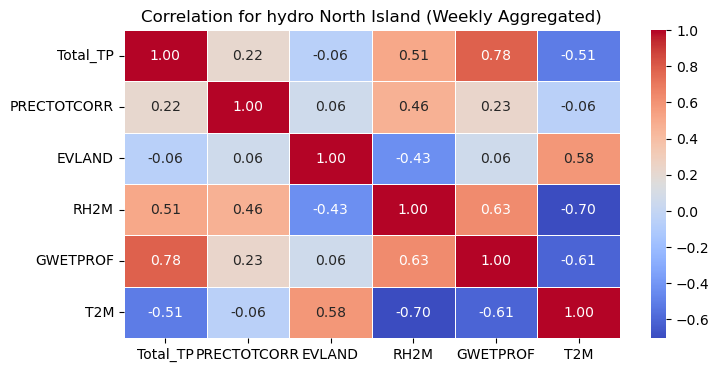

In [79]:
# Compute correlation matrix - North Island
correlation_matrix_north = df_hydro_weekly_north.corr()

# Plot heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix_north, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation for hydro North Island (Weekly Aggregated)')
plt.show()

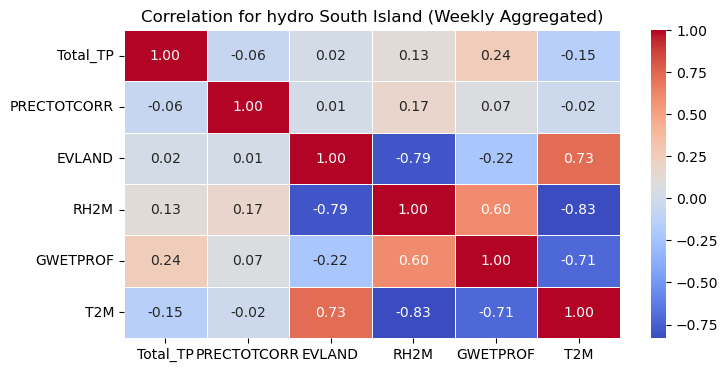

In [80]:
# Compute correlation matrix - South Island
correlation_matrix_south = df_hydro_weekly_south.corr()

# Plot heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix_south, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation for hydro South Island (Weekly Aggregated)')
plt.show()

<!-- # All Island Weekly
# df_hydro_weekly['PRECIP_7d'] = df_hydro_weekly['PRECTOTCORR'].rolling(7, min_periods=1).sum() #Rolling sums - total rain over the last 7 days
# df_hydro_weekly['PRECIP_14d'] = df_hydro_weekly['PRECTOTCORR'].rolling(14, min_periods=1).sum() #Rolling sums - total rain over the last 7 days
# df_hydro_weekly['PRECIP_lag1'] = df_hydro_weekly['PRECTOTCORR'].shift(1) # Lagged values yesterday’s rain
# df_hydro_weekly['PRECIP_lag7'] = df_hydro_weekly['PRECTOTCORR'].shift(7) # Lagged values last week’s rain
df_hydro_weekly['PRECIP_lag1w'] = df_hydro_weekly['PRECTOTCORR'].shift(1)
df_hydro_weekly['PRECIP_lag2w'] = df_hydro_weekly['PRECTOTCORR'].shift(2)
df_hydro_weekly['API_weekly'] = df_hydro_weekly['PRECTOTCORR'].ewm(alpha=0.3, adjust=False).mean() -->

In [82]:
# Add 1 to 2-week lagged climate features
df_hydro_weekly_north['TP_lag1w'] = df_hydro_weekly_north['Total_TP'].shift(1)
df_hydro_weekly_north['T2M_lag1w'] = df_hydro_weekly_north['T2M'].shift(1)
df_hydro_weekly_north['GWETPROF_lag1w'] = df_hydro_weekly_north['GWETPROF'].shift(1)
df_hydro_weekly_north['RH2M_lag1w'] = df_hydro_weekly_north['RH2M'].shift(1)
df_hydro_weekly_north['PRECIP_lag1w'] = df_hydro_weekly_north['PRECTOTCORR'].shift(1)
df_hydro_weekly_north['EVLAND_lag1w'] = df_hydro_weekly_north['EVLAND'].shift(1)
df_hydro_weekly_north['PRECIP_lag2w'] = df_hydro_weekly_north['PRECTOTCORR'].shift(2)
df_hydro_weekly_north['PRECIP_EWMA'] = df_hydro_weekly_north['PRECTOTCORR'].ewm(alpha=0.3, adjust=False).mean()
# EWMA for EVLAND with a “slow” decay (alpha = 0.1)
df_hydro_weekly_north['EVLAND_EWMA'] = df_hydro_weekly_north['EVLAND'].ewm(alpha=0.3, adjust=False).mean()
df_hydro_weekly_north['APIxGWETPROF'] = df_hydro_weekly_north['PRECIP_EWMA'] * df_hydro_weekly_north['GWETPROF']

In [83]:
df_hydro_weekly_north.head()

,Total_TP,PRECTOTCORR,EVLAND,RH2M,GWETPROF,T2M,TP_lag1w,T2M_lag1w,GWETPROF_lag1w,RH2M_lag1w,PRECIP_lag1w,EVLAND_lag1w,PRECIP_lag2w,PRECIP_EWMA,EVLAND_EWMA,APIxGWETPROF
DATE,,,,,,,,,,,,,,,,
2015-03-08,77108297.22,204.03,195.33,76.440336,0.331176,17.886723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.030000,195.330000,67.569935
2015-03-15,71245084.70,372.58,203.25,76.564454,0.338487,17.326303,77108297.22,17.886723,0.331176,76.440336,204.03,195.33,NaN,254.595000,197.706000,86.177198
2015-03-22,71202576.46,399.07,238.96,70.463782,0.368403,13.776807,71245084.70,17.326303,0.338487,76.564454,372.58,203.25,204.03,297.937500,210.082200,109.761176
2015-03-29,70920967.42,326.24,216.04,80.650000,0.360000,16.227563,71202576.46,13.776807,0.368403,70.463782,399.07,238.96,372.58,306.428250,211.869540,110.314170
2015-04-05,70933314.09,44.53,174.38,77.631261,0.362605,15.508235,70920967.42,16.227563,0.360000,80.650000,326.24,216.04,399.07,227.858775,200.622678,82.622741


In [84]:
# Drop original non-lagged features and drop NA from lagging
weekly_lagged_north = df_hydro_weekly_north[['Total_TP','TP_lag1w','PRECTOTCORR','PRECIP_lag1w','APIxGWETPROF','PRECIP_lag2w','PRECIP_EWMA','EVLAND','EVLAND_lag1w','EVLAND_EWMA','RH2M','RH2M_lag1w','GWETPROF','GWETPROF_lag1w','T2M','T2M_lag1w']].dropna()
weekly_lagged_north.head()

,Total_TP,TP_lag1w,PRECTOTCORR,PRECIP_lag1w,APIxGWETPROF,PRECIP_lag2w,PRECIP_EWMA,EVLAND,EVLAND_lag1w,EVLAND_EWMA,RH2M,RH2M_lag1w,GWETPROF,GWETPROF_lag1w,T2M,T2M_lag1w
DATE,,,,,,,,,,,,,,,,
2015-03-22,7.120258e+07,71245084.70,399.07,372.58,109.761176,204.03,297.937500,238.96,203.25,210.082200,70.463782,76.564454,0.368403,0.338487,13.776807,17.326303
2015-03-29,7.092097e+07,71202576.46,326.24,399.07,110.314170,372.58,306.428250,216.04,238.96,211.869540,80.650000,70.463782,0.360000,0.368403,16.227563,13.776807
2015-04-05,7.093331e+07,70920967.42,44.53,326.24,82.622741,399.07,227.858775,174.38,216.04,200.622678,77.631261,80.650000,0.362605,0.360000,15.508235,16.227563
2015-04-12,9.771136e+07,70933314.09,717.41,44.53,140.663256,326.24,374.724142,185.60,174.38,196.115875,85.405462,77.631261,0.375378,0.362605,16.036639,15.508235
2015-04-19,1.111432e+08,97711358.20,646.65,717.41,188.502533,44.53,456.301900,184.17,185.60,192.532112,80.490084,85.405462,0.413109,0.375378,10.195378,16.036639


In [85]:
order = ['Total_TP','TP_lag1w','PRECTOTCORR','PRECIP_lag1w','PRECIP_lag2w','PRECIP_EWMA','GWETPROF','GWETPROF_lag1w','APIxGWETPROF','EVLAND','EVLAND_lag1w','EVLAND_EWMA','RH2M','RH2M_lag1w','T2M','T2M_lag1w']
weekly_lagged_north = weekly_lagged_north[order]

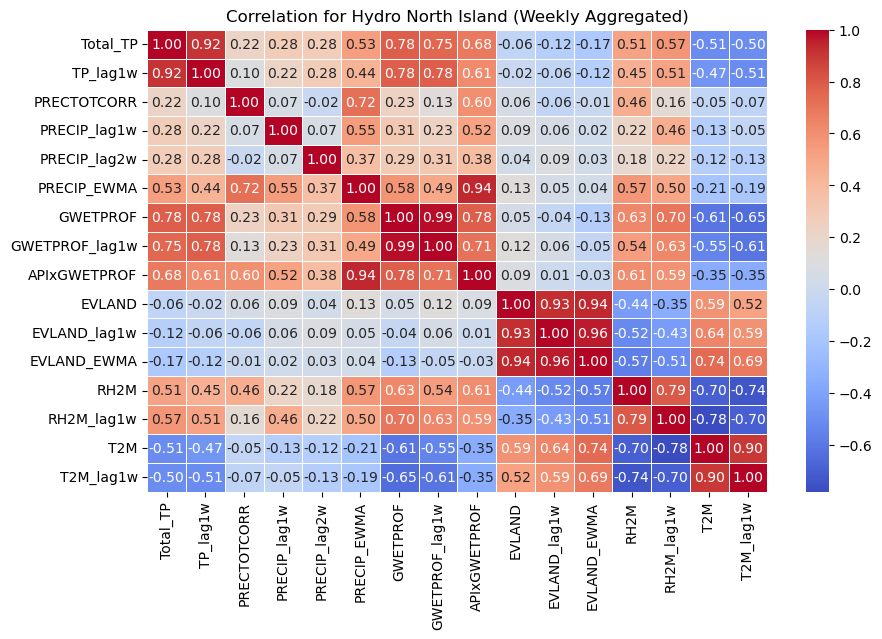

In [86]:
# Compute correlation matrix - North Island
correlation_matrix_with_lag_north = weekly_lagged_north.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix_with_lag_north, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation for Hydro North Island (Weekly Aggregated)')
plt.show()

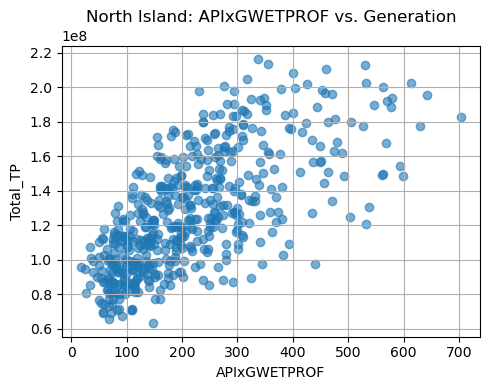

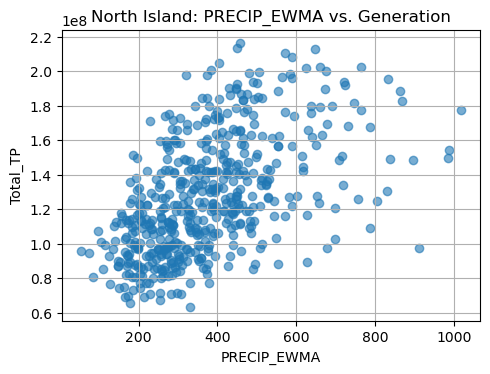

In [87]:
import matplotlib.pyplot as plt

for feat in ['APIxGWETPROF', 'PRECIP_EWMA']:
    plt.figure(figsize=(5, 4))
    plt.scatter(df_hydro_weekly_north[feat], df_hydro_weekly_north['Total_TP'], alpha=0.6)
    plt.xlabel(feat)
    plt.ylabel('Total_TP')
    plt.title(f'North Island: {feat} vs. Generation')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

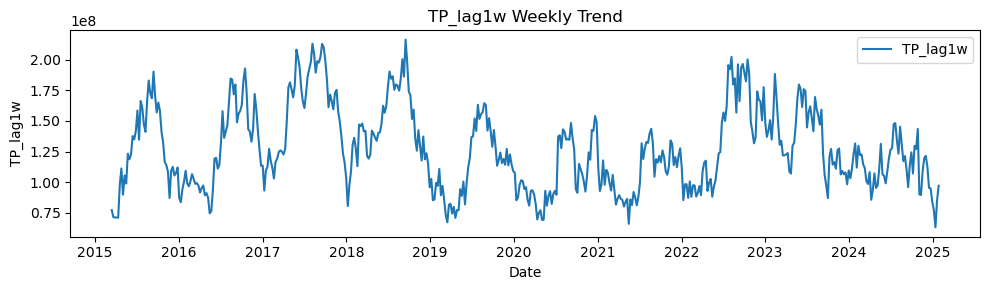

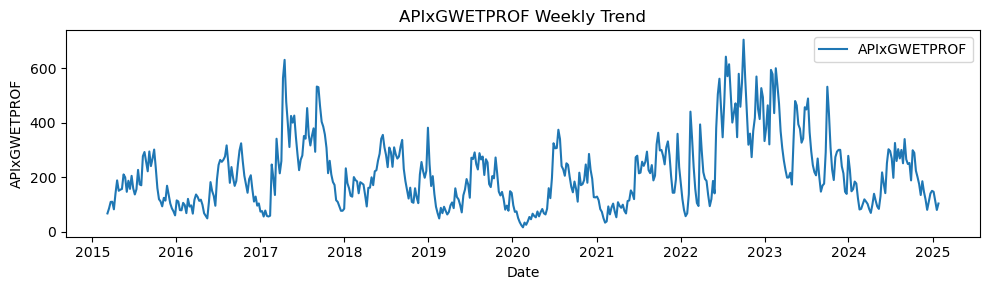

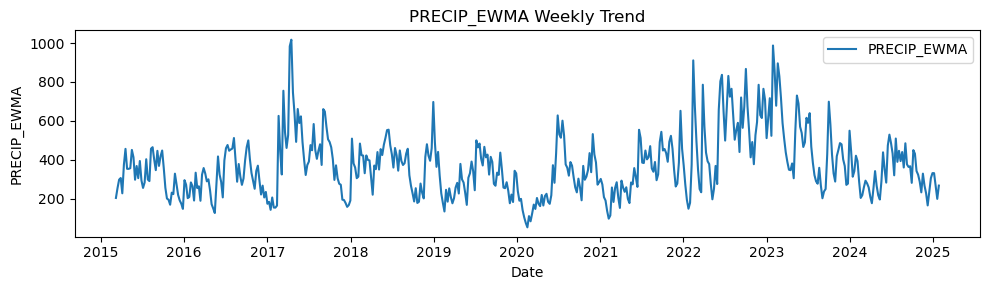

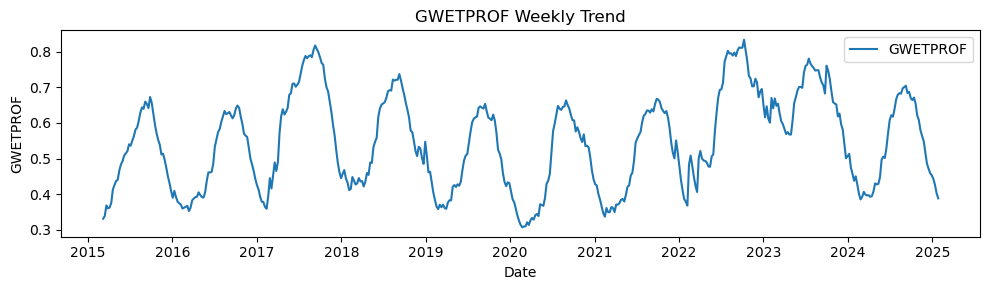

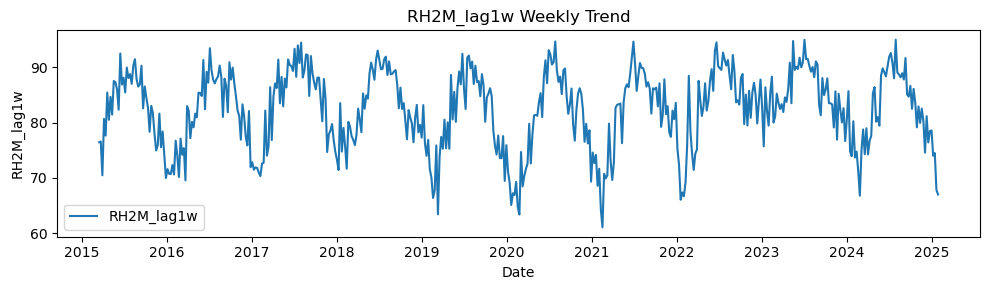

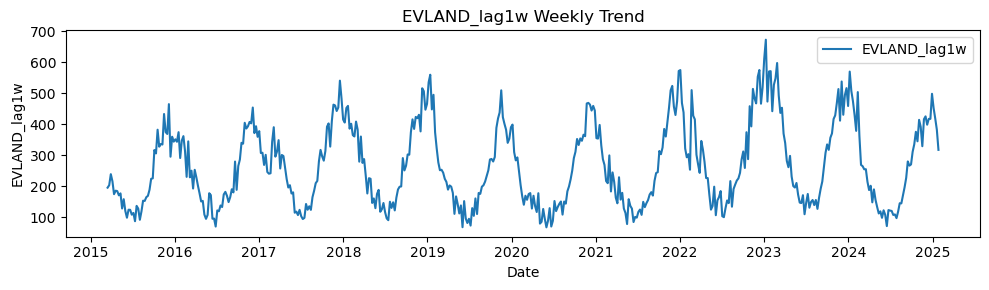

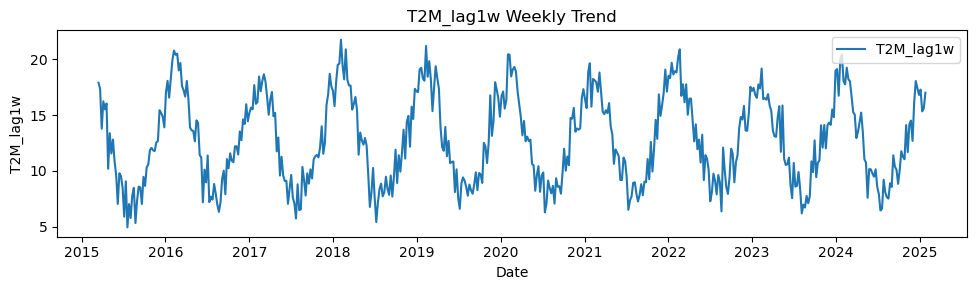

In [88]:
factors = ['TP_lag1w','APIxGWETPROF','PRECIP_EWMA','GWETPROF','RH2M_lag1w','EVLAND_lag1w','T2M_lag1w']

for f in factors:
    plt.figure(figsize=(10, 3))
    plt.plot(df_hydro_weekly_north[f], label=f)
    plt.title(f'{f} Weekly Trend')
    plt.xlabel('Date')
    plt.ylabel(f)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [89]:
# South Island 

In [90]:
# Add 1 to 2-week lagged climate features
df_hydro_weekly_south['TP_lag1w'] = df_hydro_weekly_south['Total_TP'].shift(1)
df_hydro_weekly_south['T2M_lag1w'] = df_hydro_weekly_south['T2M'].shift(1)
df_hydro_weekly_south['GWETPROF_lag1w'] = df_hydro_weekly_south['GWETPROF'].shift(1)
df_hydro_weekly_south['RH2M_lag1w'] = df_hydro_weekly_south['RH2M'].shift(1)
df_hydro_weekly_south['PRECIP_lag1w'] = df_hydro_weekly_south['PRECTOTCORR'].shift(1)
df_hydro_weekly_south['EVLAND_lag1w'] = df_hydro_weekly_south['EVLAND'].shift(1)
df_hydro_weekly_south['PRECIP_lag2w'] = df_hydro_weekly_south['PRECTOTCORR'].shift(2)
df_hydro_weekly_south['PRECIP_EWMA'] = df_hydro_weekly_south['PRECTOTCORR'].ewm(alpha=0.3, adjust=False).mean()
# EWMA for EVLAND with a “slow” decay (alpha = 0.1)
df_hydro_weekly_south['EVLAND_EWMA'] = df_hydro_weekly_south['EVLAND'].ewm(alpha=0.3, adjust=False).mean()
df_hydro_weekly_south['APIxGWETPROF'] = df_hydro_weekly_south['PRECIP_EWMA'] * df_hydro_weekly_south['GWETPROF']

In [91]:
df_hydro_weekly_south.head()

,Total_TP,PRECTOTCORR,EVLAND,RH2M,GWETPROF,T2M,TP_lag1w,T2M_lag1w,GWETPROF_lag1w,RH2M_lag1w,PRECIP_lag1w,EVLAND_lag1w,PRECIP_lag2w,PRECIP_EWMA,EVLAND_EWMA,APIxGWETPROF
DATE,,,,,,,,,,,,,,,,
2015-03-08,3.203293e+08,767.35,258.66,76.412937,0.467698,12.941190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,767.350000,258.660000,358.888377
2015-03-15,3.243453e+08,156.42,228.78,77.127698,0.480000,12.604048,3.203293e+08,12.941190,0.467698,76.412937,767.35,258.66,NaN,584.071000,249.696000,280.354080
2015-03-22,2.950068e+08,264.80,165.01,80.292381,0.474921,8.037778,3.243453e+08,12.604048,0.480000,77.127698,156.42,228.78,767.35,488.289700,224.290200,231.898854
2015-03-29,2.870318e+08,367.40,154.86,83.572698,0.482063,11.639524,2.950068e+08,8.037778,0.474921,80.292381,264.80,165.01,156.42,452.022790,203.461140,217.903685
2015-04-05,2.590456e+08,189.24,177.98,79.877222,0.490952,11.092937,2.870318e+08,11.639524,0.482063,83.572698,367.40,154.86,264.80,373.187953,195.816798,183.217514


In [92]:
# Drop original non-lagged features and drop NA from lagging
weekly_lagged_south = df_hydro_weekly_south[['Total_TP','TP_lag1w','PRECTOTCORR','PRECIP_lag1w','APIxGWETPROF','PRECIP_lag2w','PRECIP_EWMA','EVLAND','EVLAND_lag1w','EVLAND_EWMA','RH2M','RH2M_lag1w','GWETPROF','GWETPROF_lag1w','T2M','T2M_lag1w']].dropna()
weekly_lagged_south.head()

,Total_TP,TP_lag1w,PRECTOTCORR,PRECIP_lag1w,APIxGWETPROF,PRECIP_lag2w,PRECIP_EWMA,EVLAND,EVLAND_lag1w,EVLAND_EWMA,RH2M,RH2M_lag1w,GWETPROF,GWETPROF_lag1w,T2M,T2M_lag1w
DATE,,,,,,,,,,,,,,,,
2015-03-22,2.950068e+08,3.243453e+08,264.80,156.42,231.898854,767.35,488.289700,165.01,228.78,224.290200,80.292381,77.127698,0.474921,0.480000,8.037778,12.604048
2015-03-29,2.870318e+08,2.950068e+08,367.40,264.80,217.903685,156.42,452.022790,154.86,165.01,203.461140,83.572698,80.292381,0.482063,0.474921,11.639524,8.037778
2015-04-05,2.590456e+08,2.870318e+08,189.24,367.40,183.217514,264.80,373.187953,177.98,154.86,195.816798,79.877222,83.572698,0.490952,0.482063,11.092937,11.639524
2015-04-12,2.441813e+08,2.590456e+08,470.76,189.24,202.251903,367.40,402.459567,166.54,177.98,187.033759,83.569683,79.877222,0.502540,0.490952,9.989206,11.092937
2015-04-19,2.735290e+08,2.441813e+08,333.51,470.76,198.916737,189.24,381.774697,129.33,166.54,169.722631,85.104524,83.569683,0.521032,0.502540,4.725635,9.989206


In [93]:
order = ['Total_TP','TP_lag1w','PRECTOTCORR','PRECIP_lag1w','PRECIP_lag2w','PRECIP_EWMA','GWETPROF','GWETPROF_lag1w','APIxGWETPROF','EVLAND','EVLAND_lag1w','EVLAND_EWMA','RH2M','RH2M_lag1w','T2M','T2M_lag1w']
weekly_lagged_south = weekly_lagged_south[order]

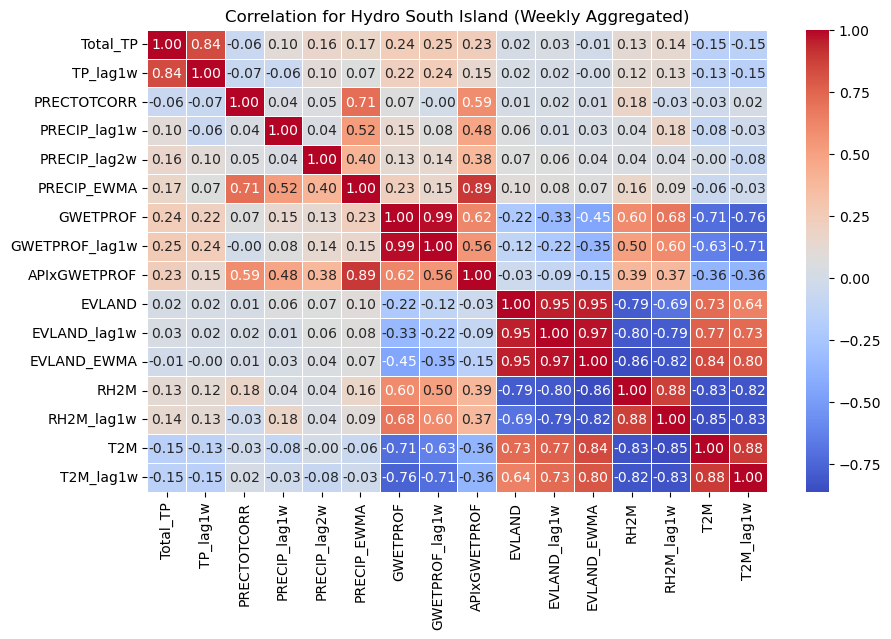

In [94]:
# Compute correlation matrix - South Island
correlation_matrix_with_lag_south = weekly_lagged_south.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix_with_lag_south, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation for Hydro South Island (Weekly Aggregated)')
plt.show()

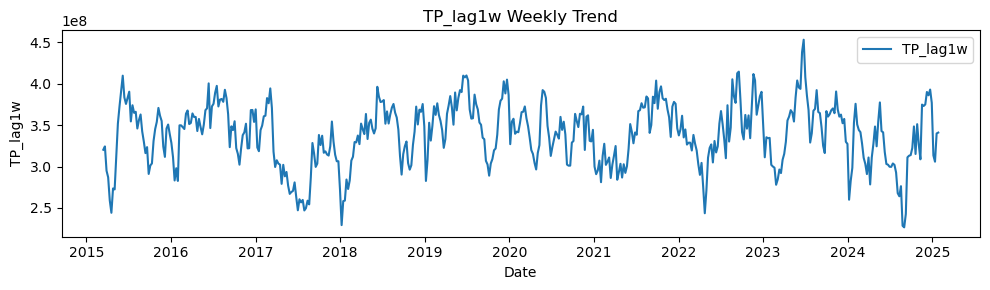

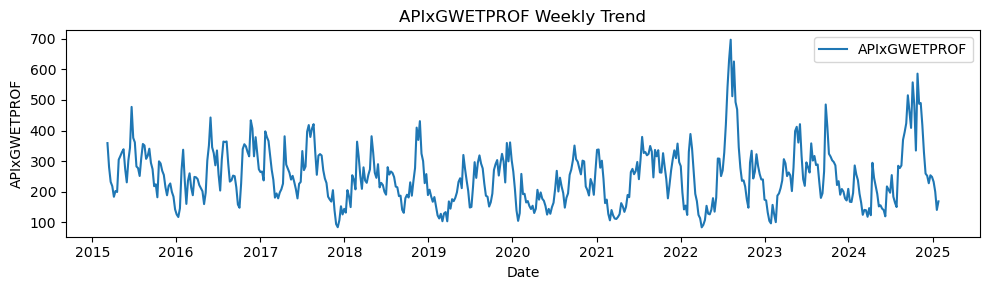

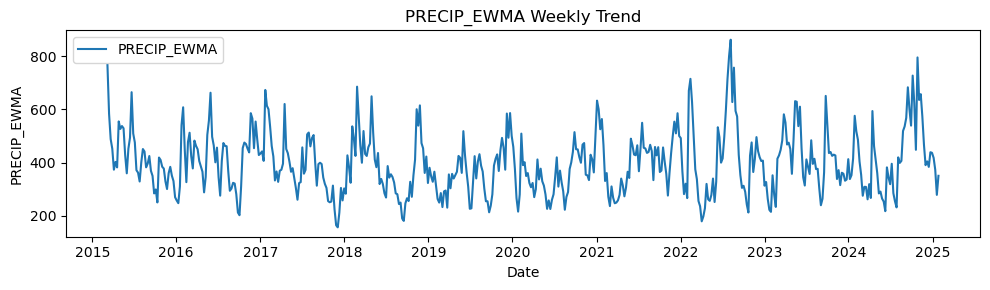

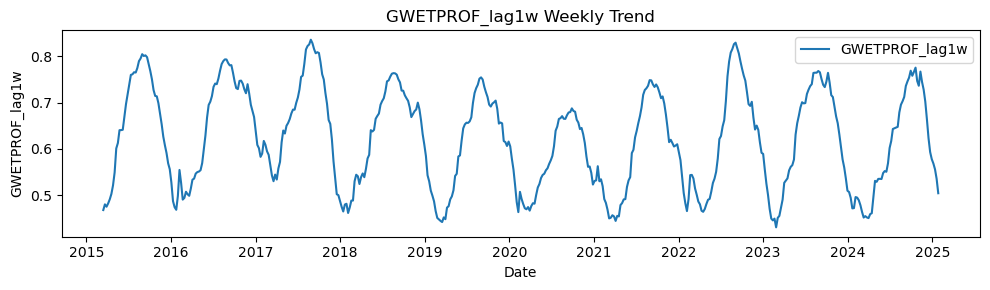

In [95]:
factors = ['TP_lag1w','APIxGWETPROF','PRECIP_EWMA','GWETPROF_lag1w']

for f in factors:
    plt.figure(figsize=(10, 3))
    plt.plot(df_hydro_weekly_south[f], label=f)
    plt.title(f'{f} Weekly Trend')
    plt.xlabel('Date')
    plt.ylabel(f)
    plt.legend()
    plt.tight_layout()
    plt.show()

# SARIMA model for hydro

## Pre Checks - stationery

In [190]:
# Frequency setting 'W' (weekly)
df_hydro_weekly_north.head()
df_hydro_weekly_north.index.freq  

<Week: weekday=6>

In [192]:
weekly_lagged_north.head()
weekly_lagged_north.index.freq  

<Week: weekday=6>

In [194]:
weekly_lagged_north.head()

,Total_TP,TP_lag1w,PRECTOTCORR,PRECIP_lag1w,PRECIP_lag2w,PRECIP_EWMA,GWETPROF,GWETPROF_lag1w,APIxGWETPROF,EVLAND,EVLAND_lag1w,EVLAND_EWMA,RH2M,RH2M_lag1w,T2M,T2M_lag1w
DATE,,,,,,,,,,,,,,,,
2015-03-22,7.120258e+07,71245084.70,399.07,372.58,204.03,297.937500,0.368403,0.338487,109.761176,238.96,203.25,210.082200,70.463782,76.564454,13.776807,17.326303
2015-03-29,7.092097e+07,71202576.46,326.24,399.07,372.58,306.428250,0.360000,0.368403,110.314170,216.04,238.96,211.869540,80.650000,70.463782,16.227563,13.776807
2015-04-05,7.093331e+07,70920967.42,44.53,326.24,399.07,227.858775,0.362605,0.360000,82.622741,174.38,216.04,200.622678,77.631261,80.650000,15.508235,16.227563
2015-04-12,9.771136e+07,70933314.09,717.41,44.53,326.24,374.724142,0.375378,0.362605,140.663256,185.60,174.38,196.115875,85.405462,77.631261,16.036639,15.508235
2015-04-19,1.111432e+08,97711358.20,646.65,717.41,44.53,456.301900,0.413109,0.375378,188.502533,184.17,185.60,192.532112,80.490084,85.405462,10.195378,16.036639


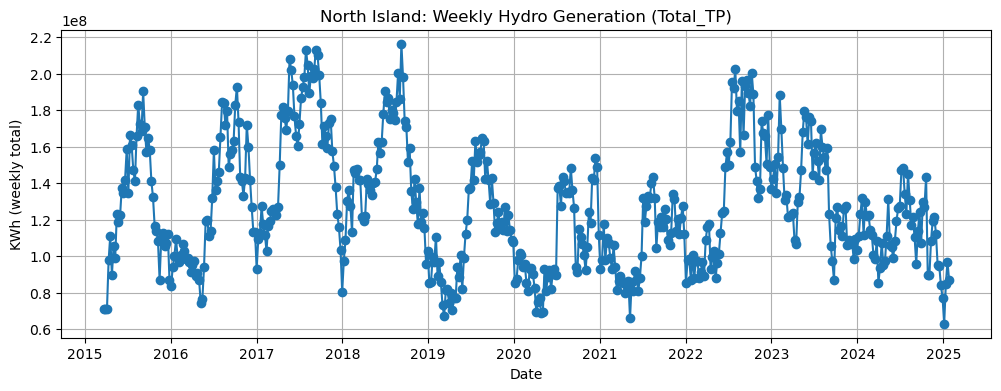

In [196]:
plt.figure(figsize=(12,4))
plt.plot(weekly_lagged_north['Total_TP'], marker='o', linestyle='-')
plt.title("North Island: Weekly Hydro Generation (Total_TP)")
plt.ylabel("KWh (weekly total)")
plt.xlabel("Date")
plt.grid(True)
plt.show()

In [198]:
# stationery check for north Island weekly data
from statsmodels.tsa.stattools import adfuller

result = adfuller(weekly_lagged_north['Total_TP'])
print('stationery check for North Island - Weekly' )
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

stationery check for North Island - Weekly
ADF Statistic: -4.839144
p-value: 0.000046
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


In [200]:
# stationery check for South Island Weekly data
from statsmodels.tsa.stattools import adfuller


result = adfuller(weekly_lagged_south['Total_TP'])
print('stationery check for South Island - Weekly ' )
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

stationery check for South Island - Weekly 
ADF Statistic: -6.723656
p-value: 0.000000
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


In [202]:
north = weekly_lagged_north['Total_TP']
south = weekly_lagged_south['Total_TP']

# Model Development 

## Start North Island - Weekly 

In [206]:
# Repeat the same steps for North Island:
series_n = north
n_n = len(series_n)
split_n = int(n_n * 0.8)

train_n = series_n.iloc[:split_n]
test_n  = series_n.iloc[split_n:]

model_n = SARIMAX(
    train_n,
    order=(0, 0, 2),
    seasonal_order=(1, 0, 0, 52),
    enforce_stationarity=False,
    enforce_invertibility=False
)
res_n = model_n.fit(disp=False)
print(res_n.summary())

fc_n = res_n.get_forecast(steps=len(test_n))
pred_n = pd.Series(fc_n.predicted_mean.values, index=test_n.index)

mae_n  = mean_absolute_error(test_n, pred_n)
rmse_n = np.sqrt(mean_squared_error(test_n, pred_n))
mape_n = np.mean(np.abs((test_n - pred_n) / test_n)) * 100

# rmse = np.sqrt(mean_squared_error(target_test, forecast))
# mae = mean_absolute_error(target_test, forecast)
# epsilon = 1e-10  # small constant to avoid division by zero in MAPE
# mape = np.mean(np.abs((target_test - forecast) / (target_test + epsilon))) * 100

print("North Island SARIMA(1, 0, 1)x(0, 0, 1, 52) → MAE:", f"{mae_n:.2f}",
      "RMSE:", f"{rmse_n:.2f}", "MAPE:", f"{mape_n:.2f}%")

                                      SARIMAX Results                                      
Dep. Variable:                            Total_TP   No. Observations:                  412
Model:             SARIMAX(0, 0, 2)x(1, 0, [], 52)   Log Likelihood               -7070.609
Date:                             Thu, 05 Jun 2025   AIC                          14149.218
Time:                                     07:37:28   BIC                          14164.763
Sample:                                 03-22-2015   HQIC                         14155.399
                                      - 02-05-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.8216      1.843      0.446      0.656      -2.790       4.434
ma.L2          0.4413      

In [208]:
### ANN for comparison ###

#   Set seeds for reproducibility  
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# 2) Data prep (no randomness here, aside from ’shift’ which is deterministic)
df_ann_hydro_north_wk = weekly_lagged_north[['Total_TP','TP_lag1w']]

n_hydro_ann     = len(df_ann_hydro_north_wk)
split_ann = int(n_hydro_ann * 0.8)

train_n_ann = df_ann_hydro_north_wk.iloc[:split_ann]
test_n_ann  = df_ann_hydro_north_wk.iloc[split_ann:]

X_train_n_ann = train_n_ann[['TP_lag1w']].values
y_train_n_ann = train_n_ann['Total_TP'].values.reshape(-1,1)
X_test_n_ann  = test_n_ann[['TP_lag1w']].values
y_test_n_ann  = test_n_ann['Total_TP'].values.reshape(-1,1)


# 3) Scaling
scaler_X = MinMaxScaler()
X_train_s_n_ann = scaler_X.fit_transform(X_train_n_ann)
X_test_s_n_ann  = scaler_X.transform(X_test_n_ann)

scaler_y = MinMaxScaler()
y_train_s_n_ann = scaler_y.fit_transform(y_train_n_ann)
# (We hold off on transforming y_test because we want raw y_test for metrics.)

# 4) Build the ANN
model_ann = Sequential([
    Dense(16, activation='relu', input_shape=(1,)),
    Dense(8,  activation='relu'),
    Dense(1)
])
model_ann.compile(optimizer='adam', loss='mse')

# 5) Train the ANN (the shuffle order is now deterministic)
history = model_ann.fit(
    X_train_s_n_ann, y_train_s_n_ann,
    epochs=100,
    batch_size=16,
    validation_split=0.05,
    verbose=0
)

# 6) Predict & rescale
y_pred_s_n_ann = model_ann.predict(X_test_s_n_ann)
y_pred_n_ann   = scaler_y.inverse_transform(y_pred_s_n_ann).flatten()


# 7) Metrics on raw scale
mae_ann  = mean_absolute_error(y_test_n_ann.flatten(), y_pred_n_ann)
rmse_ann = np.sqrt(mean_squared_error(y_test_n_ann.flatten(), y_pred_n_ann))
mape_ann = np.mean(np.abs((y_test_n_ann.flatten() - y_pred_n_ann) / y_test_n_ann.flatten())) * 100

#print(f"Univariate ANN - MAE: {mae_ann:.2f}, RMSE: {rmse_ann:.2f}, MAPE: {mape_ann:.2f}%")

print("North Island ANN → MAE:", f"{mae_ann:.2f}",
      "RMSE:", f"{rmse_ann:.2f}", "MAPE:", f"{mape_ann:.2f}%")

C:\Users\nwn86\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
North Island ANN → MAE: 11263851.50 RMSE: 14145051.16 MAPE: 9.71%


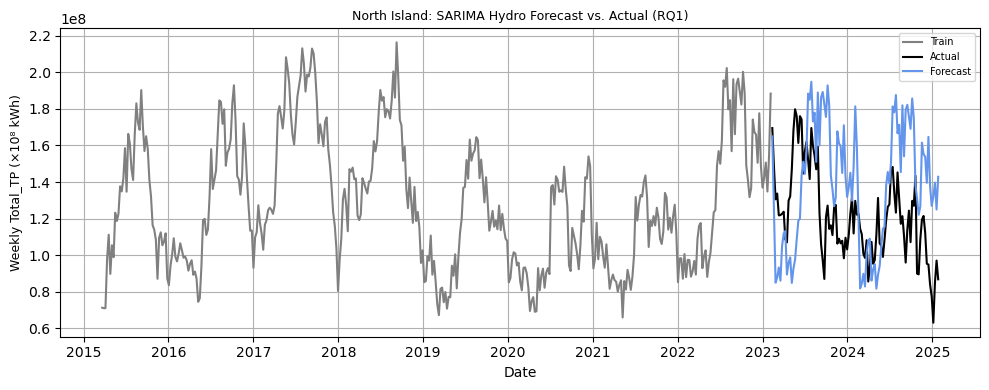

In [214]:
# Repeat a similar plot for North Island:
plt.figure(figsize=(10,4))
plt.plot(train_n.index, train_n, label="Train",   color="gray")
plt.plot(test_n.index,  test_n,  label="Actual",  color="black")
plt.plot(pred_n.index,  pred_n,  label="Forecast",color="cornflowerblue")
# plt.fill_between(
#     fc_n.conf_int().index,
#     fc_n.conf_int().iloc[:,0],
#     fc_n.conf_int().iloc[:,1],
#     color="lightblue", alpha=0.2
# )
plt.legend()
plt.title("North Island: SARIMA Hydro Forecast vs. Actual (RQ1)" , fontsize=9)
plt.xlabel("Date")
plt.ylabel("Weekly Total_TP (×10⁸ kWh)" ,  fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.legend(loc="upper right", fontsize=7)
plt.show()

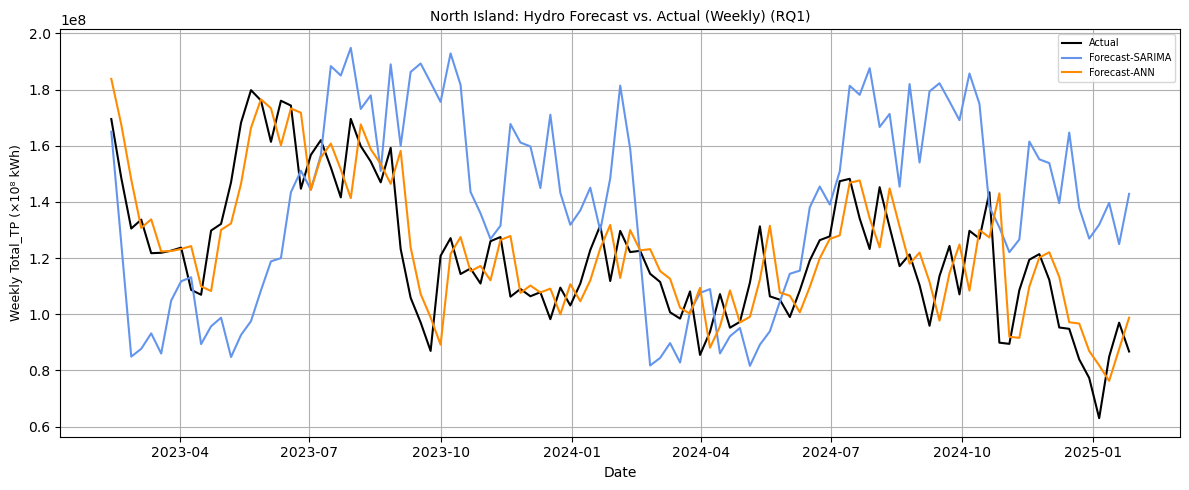

In [210]:
# Repeat a similar plot for North Island:
plt.figure(figsize=(12,5))
#plt.plot(train_n.index, train_n, label="Train",   color="gray")
plt.plot(test_n.index,  test_n,  label="Actual",  color="black")
plt.plot(pred_n.index,  pred_n,  label="Forecast-SARIMA",color="cornflowerblue")
plt.plot(test_n_ann.index, y_pred_n_ann, label="Forecast-ANN",      color="darkorange")
# plt.fill_between(
#     fc_n.conf_int().index,
#     fc_n.conf_int().iloc[:,0],
#     fc_n.conf_int().iloc[:,1],
#     color="lightblue", alpha=0.2
# )
plt.legend()
plt.title("North Island: Hydro Forecast vs. Actual (Weekly) (RQ1)" , fontsize=10)
plt.xlabel("Date")
plt.ylabel("Weekly Total_TP (×10⁸ kWh)" ,  fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.legend(loc="upper right", fontsize=7)
plt.show()

In [212]:
weekly_lagged_north

,Total_TP,TP_lag1w,PRECTOTCORR,PRECIP_lag1w,PRECIP_lag2w,PRECIP_EWMA,GWETPROF,GWETPROF_lag1w,APIxGWETPROF,EVLAND,EVLAND_lag1w,EVLAND_EWMA,RH2M,RH2M_lag1w,T2M,T2M_lag1w
DATE,,,,,,,,,,,,,,,,
2015-03-22,7.120258e+07,71245084.70,399.07,372.58,204.03,297.937500,0.368403,0.338487,109.761176,238.96,203.25,210.082200,70.463782,76.564454,13.776807,17.326303
2015-03-29,7.092097e+07,71202576.46,326.24,399.07,372.58,306.428250,0.360000,0.368403,110.314170,216.04,238.96,211.869540,80.650000,70.463782,16.227563,13.776807
2015-04-05,7.093331e+07,70920967.42,44.53,326.24,399.07,227.858775,0.362605,0.360000,82.622741,174.38,216.04,200.622678,77.631261,80.650000,15.508235,16.227563
2015-04-12,9.771136e+07,70933314.09,717.41,44.53,326.24,374.724142,0.375378,0.362605,140.663256,185.60,174.38,196.115875,85.405462,77.631261,16.036639,15.508235
2015-04-19,1.111432e+08,97711358.20,646.65,717.41,44.53,456.301900,0.413109,0.375378,188.502533,184.17,185.60,192.532112,80.490084,85.405462,10.195378,16.036639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-29,7.731263e+07,83933260.00,391.50,468.64,400.52,331.569510,0.453025,0.458739,150.209347,452.03,498.24,438.334654,74.004958,78.571765,17.281008,16.798655
2025-01-05,6.298005e+07,77312627.00,331.19,391.50,468.64,331.455657,0.442689,0.453025,146.731798,418.69,452.03,432.441258,74.479328,74.004958,15.331933,17.281008
2025-01-12,8.487436e+07,62980054.00,108.94,331.19,391.50,264.700960,0.425630,0.442689,112.664736,382.43,418.69,417.437880,67.837059,74.479328,15.599916,15.331933


In [214]:
# Split the weekly data into 80% training and 20% testing sets
n = len(weekly_lagged_north)
train_size = int(n * 0.8)
train_wk = weekly_lagged_north.iloc[:train_size]
test_wk = weekly_lagged_north.iloc[train_size:]

In [216]:
print("Daily Train set:", train_wk.index.min(), "to", train_wk.index.max())
print("Daily Test set:", test_wk.index.min(), "to", test_wk.index.max())

Daily Train set: 2015-03-22 00:00:00 to 2023-02-05 00:00:00
Daily Test set: 2023-02-12 00:00:00 to 2025-01-26 00:00:00


In [218]:
# Define the target variable (original Total_TP) and exogenous variables
# target_train_log = train_weekly['Total_TP_log']
# target_test_log = test_weekly['Total_TP_log']

target_train = train_wk['Total_TP']
target_test = test_wk['Total_TP']



In [220]:
#exog_cols = ['TP_lag1w','APIxGWETPROF','PRECIP_EWMA','GWETPROF','RH2M_lag1w','EVLAND_lag1w','T2M_lag1w' ]
#exog_cols = ['APIxGWETPROF','PRECIP_EWMA','GWETPROF','RH2M_lag1w','EVLAND_lag1w','T2M_lag1w' ]
#exog_cols = ['RH2M', 'GWETPROF', 'EVLAND', 'T2M']
#exog_cols = ['RH2M', 'GWETPROF', 'EVLAND', 'T2M','PRECTOTCORR_lag1']
#exog_cols = ['T2M','PRECTOTCORR_lag7','GWETPROF']
#exog_cols = ['EVLAND','T2M']
#exog_cols = ['GWETPROF','EVLAND','T2M']
#exog_cols = ['PRECTOTCORR','GWETPROF','EVLAND','T2M']
#exog_cols = ['RH2M','PRECTOTCORR','GWETPROF','EVLAND','T2M']
#exog_cols = ['WS50M']
#exog_cols = ['APIxGWETPROF','PRECIP_EWMA','GWETPROF','RH2M_lag1w','EVLAND_lag1w','T2M_lag1w' ]
#exog_cols = ['TP_lag1w','APIxGWETPROF','PRECIP_EWMA','GWETPROF','RH2M_lag1w' ]

exog_cols = ['TP_lag1w', 'RH2M_lag1w', 'PRECIP_EWMA']

In [222]:
exog_train = train_wk[exog_cols]
exog_test = test_wk[exog_cols]

In [224]:
# Fit SARIMAX on the original (non-log) target data
model = SARIMAX(target_train,
                exog=exog_train,
                # order=(1, 1, 1),
                # seasonal_order=(0, 0, 0, 0),
                order=(0, 0, 2),
                seasonal_order=(1, 0, 0, 52),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit(disp=False)
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                            Total_TP   No. Observations:                  412
Model:             SARIMAX(0, 0, 2)x(1, 0, [], 52)   Log Likelihood               -6379.006
Date:                             Thu, 05 Jun 2025   AIC                          12772.013
Time:                                     07:39:58   BIC                          12799.215
Sample:                                 03-22-2015   HQIC                         12782.829
                                      - 02-05-2023                                         
Covariance Type:                               opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
TP_lag1w        0.8256      0.025     32.678      0.000       0.776       0.875
RH2M_lag1w    1.19e+05  

In [226]:
# Forecast on the test set - non log
n_steps = len(test_wk)
forecast = results.get_forecast(steps=n_steps, exog=exog_test).predicted_mean

# fc_n = res_n.get_forecast(steps=len(test_n))
# pred_n = pd.Series(fc_n.predicted_mean.values, index=test_n.index)

In [228]:
# Compute performance metrics - non log
rmse = np.sqrt(mean_squared_error(target_test, forecast))
mae = mean_absolute_error(target_test, forecast)
epsilon = 1e-10  # small constant to avoid division by zero in MAPE
mape = np.mean(np.abs((target_test - forecast) / (target_test + epsilon))) * 100

# print("\nForecast Performance Metrics (Without Log Transformation):")
# print(f"RMSE: {rmse:.2f}")
# print(f"MAE: {mae:.2f}")
# print(f"Adjusted MAPE: {mape:.2f}%")
print("North Island SARIMA with exog (0, 0, 2)x(1, 0, 0, 52) → MAE:", f"{mae:.2f}",
      "RMSE:", f"{rmse:.2f}", "MAPE:", f"{mape:.2f}%")

North Island SARIMA with exog (0, 0, 2)x(1, 0, 0, 52) → MAE: 11210000.28 RMSE: 13990826.65 MAPE: 9.79%


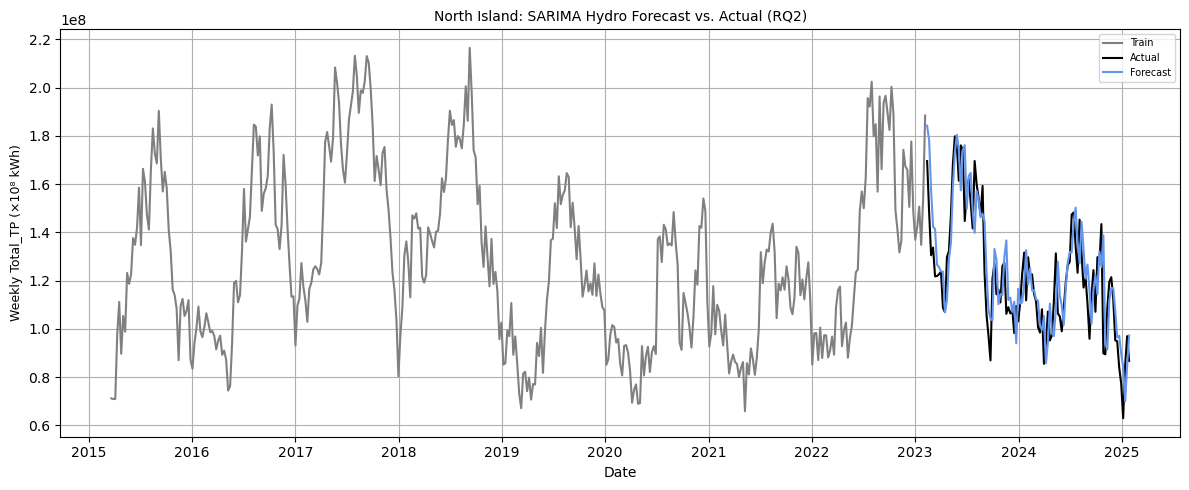

In [240]:
# Repeat a similar plot for North Island:
plt.figure(figsize=(12,5))
plt.plot(train_wk.index, target_train, label="Train",   color="gray")
plt.plot(test_wk.index,  target_test,  label="Actual",  color="black")
plt.plot(forecast.index,  forecast,  label="Forecast",color="cornflowerblue")
# plt.fill_between(
#     fc_n.conf_int().index,
#     fc_n.conf_int().iloc[:,0],
#     fc_n.conf_int().iloc[:,1],
#     color="lightblue", alpha=0.2
# )
plt.legend()
plt.title("North Island: SARIMA Hydro Forecast vs. Actual (RQ2)" , fontsize=10)
plt.xlabel("Date")
plt.ylabel("Weekly Total_TP (×10⁸ kWh)" ,  fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.legend(loc="upper right", fontsize=7)
plt.show()

# # Plot Actual vs. Forecast North Island Hydro
# plt.figure(figsize=(12, 5))
# plt.plot(train_wk.index, target_train, label='Train', color='blue')
# plt.plot(test_wk.index, target_test, label='Test', color='green')
# plt.plot(test_wk.index, forecast, label='Forecast', color='red', linestyle='--')
# plt.xlabel("Date")
# plt.ylabel("Total_TP")
# plt.title("Hydro weekly forecast using SARIMA - North Island (Without Log Transformation)")
# plt.legend()
# plt.tight_layout()
# plt.show()

In [230]:
### ANN for comparison ###

factors_n_ann = ['TP_lag1w', 'PRECIP_EWMA']

# 2) Split via slicing
n = len(weekly_lagged_north)
split_idx = int(n * 0.8)

train_df_n_ann = weekly_lagged_north.iloc[:split_idx]
test_df_n_ann  = weekly_lagged_north.iloc[split_idx:]

# 3) Extract raw X and y for train/test
X_train_raw_n_ann = train_df_n_ann[factors_n_ann].values
X_test_raw_n_ann  = test_df_n_ann[factors_n_ann].values
y_train_raw_n_ann = train_df_n_ann['Total_TP'].values.reshape(-1, 1)
y_test_raw_n_ann  = test_df_n_ann['Total_TP'].values.reshape(-1, 1)

# 4) Scale
x_scaler = StandardScaler().fit(X_train_raw_n_ann)
y_scaler = StandardScaler().fit(y_train_raw_n_ann)

X_train_n_ann = x_scaler.transform(X_train_raw_n_ann)
X_test_n_ann  = x_scaler.transform(X_test_raw_n_ann)
y_train_n_ann = y_scaler.transform(y_train_raw_n_ann)
y_test_n_ann  = y_scaler.transform(y_test_raw_n_ann)

# 5) Sanity‐check shapes
print(X_train_n_ann.shape, y_train_n_ann.shape)
print(X_test_n_ann.shape,  y_test_n_ann.shape)

# optimizer with clipping & lower LR
opt = tf.keras.optimizers.Adam(learning_rate=5e-4, clipnorm=1.0)

# #model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model = Sequential([
    Dense(64, input_shape=(X_train_n_ann.shape[1],)),  # start with 64 neurons
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),

    Dense(32),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),

    Dense(16),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),

    Dense(1)  # linear output for regression
])


model.compile(
    optimizer=opt,
    loss=Huber(delta=0.5),
    metrics=[tf.keras.metrics.MeanAbsolutePercentageError(name='mape')]
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

# ── 5) Train (use 10% of train_df as internal validation, keep test_df fully unseen) ──
history = model.fit(
    X_train_n_ann, y_train_n_ann,
    validation_split=0.10,  # 10% of training for validation
    epochs=200,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# 1) Predict & inverse‑scale
y_pred_s_n_ann = model.predict(X_test_n_ann)
y_pred_n_ann = y_scaler.inverse_transform(y_pred_s_n_ann).ravel()
y_true_n_ann = y_scaler.inverse_transform(y_test_n_ann).ravel()


# 2) Metrics
mae  = mean_absolute_error(y_true_n_ann, y_pred_n_ann)
#rmse = mean_squared_error(y_true, y_pred, squared=False)
rmse = root_mean_squared_error(y_true_n_ann, y_pred_n_ann)
mape = mean_absolute_percentage_error(y_true_n_ann, y_pred_n_ann) * 100
# print("\nRQ2‐ANN Performance - Hydro (North Island):")
# print(f"MAE : {mae:,.2f}")
# print(f"RMSE: {rmse:,.2f}")
# print(f"MAPE: {mape:.2f}%")
print("RQ2-North Island ANN (with regressors) → MAE:", f"{mae:.2f}",
      "RMSE:", f"{rmse:.2f}", "MAPE:", f"{mape:.2f}%")

# # 3) Plot
# plt.figure(figsize=(12,5))
# plt.plot(dates_test, y_true, label="Actual")
# plt.plot(dates_test, y_pred, linestyle="--", color="red", label="Predicted")
# plt.title("Sliding‑Window MLP: Actual vs. Predicted")
# plt.xlabel("Date")
# plt.ylabel("Total_TP")
# plt.legend()
# plt.tight_layout()
# plt.show()


(412, 2) (412, 1)
(103, 2) (103, 1)
Epoch 1/200


C:\Users\nwn86\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\nwn86\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.4642 - mape: 224.5731 - val_loss: 0.4047 - val_mape: 103.2327 - learning_rate: 5.0000e-04
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3178 - mape: 181.5711 - val_loss: 0.3599 - val_mape: 92.4565 - learning_rate: 5.0000e-04
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2066 - mape: 132.2389 - val_loss: 0.3344 - val_mape: 87.4016 - learning_rate: 5.0000e-04
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1707 - mape: 162.5216 - val_loss: 0.3118 - val_mape: 82.5455 - learning_rate: 5.0000e-04
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1569 - mape: 147.9105 - val_loss: 0.2955 - val_mape: 79.3979 - learning_rate: 5.0000e-04
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1583 - mape: 158.5605 - val_loss: 0.2792 - val_mape: 75.5502 - learning_rate: 5.0000e-04
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1373 - mape: 148.4594 - val_loss: 0.2631 - val_ma

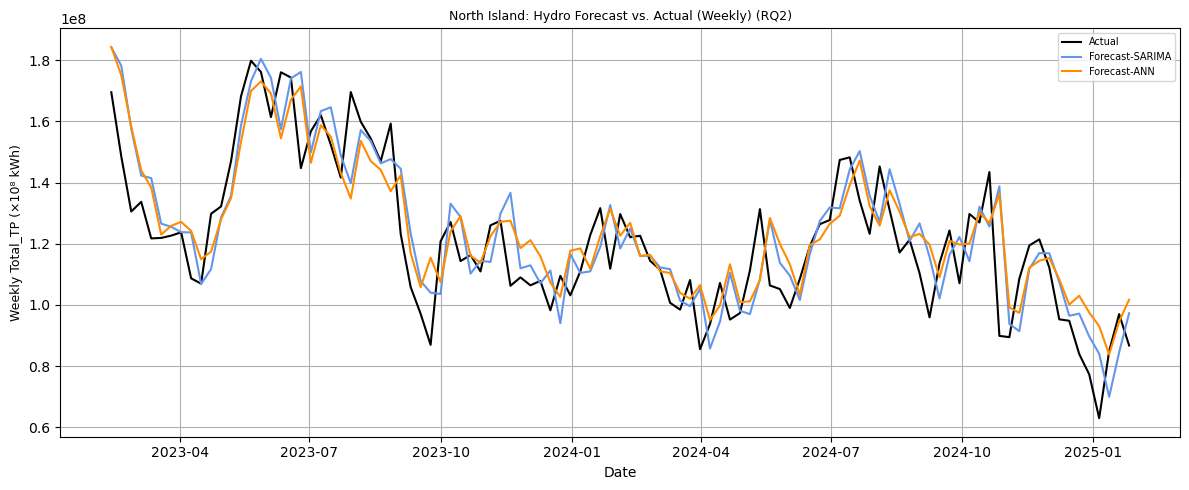

In [232]:
# Repeat a similar plot for North Island:
plt.figure(figsize=(12,5))
#plt.plot(train_wk.index, target_train, label="Train",   color="gray")
plt.plot(test_wk.index,  target_test,  label="Actual",  color="black")
plt.plot(forecast.index,  forecast,  label="Forecast-SARIMA",color="cornflowerblue")
plt.plot(test_df_n_ann.index,y_pred_n_ann,label="Forecast-ANN",color="darkorange")
# plt.fill_between(
#     fc_n.conf_int().index,
#     fc_n.conf_int().iloc[:,0],
#     fc_n.conf_int().iloc[:,1],
#     color="lightblue", alpha=0.2
# )
plt.legend()
plt.title("North Island: Hydro Forecast vs. Actual (Weekly) (RQ2)" , fontsize=9)
plt.xlabel("Date")
plt.ylabel("Weekly Total_TP (×10⁸ kWh)" ,  fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.legend(loc="upper right", fontsize=7)
plt.show()
# plt.title("North Island: Hydro Forecast vs. Actual (Weekly) (RQ1)" , fontsize=10)

In [244]:
weekly_lagged_north

,Total_TP,TP_lag1w,PRECTOTCORR,PRECIP_lag1w,PRECIP_lag2w,PRECIP_EWMA,GWETPROF,GWETPROF_lag1w,APIxGWETPROF,EVLAND,EVLAND_lag1w,EVLAND_EWMA,RH2M,RH2M_lag1w,T2M,T2M_lag1w
DATE,,,,,,,,,,,,,,,,
2015-03-22,7.120258e+07,71245084.70,399.07,372.58,204.03,297.937500,0.368403,0.338487,109.761176,238.96,203.25,210.082200,70.463782,76.564454,13.776807,17.326303
2015-03-29,7.092097e+07,71202576.46,326.24,399.07,372.58,306.428250,0.360000,0.368403,110.314170,216.04,238.96,211.869540,80.650000,70.463782,16.227563,13.776807
2015-04-05,7.093331e+07,70920967.42,44.53,326.24,399.07,227.858775,0.362605,0.360000,82.622741,174.38,216.04,200.622678,77.631261,80.650000,15.508235,16.227563
2015-04-12,9.771136e+07,70933314.09,717.41,44.53,326.24,374.724142,0.375378,0.362605,140.663256,185.60,174.38,196.115875,85.405462,77.631261,16.036639,15.508235
2015-04-19,1.111432e+08,97711358.20,646.65,717.41,44.53,456.301900,0.413109,0.375378,188.502533,184.17,185.60,192.532112,80.490084,85.405462,10.195378,16.036639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-29,7.731263e+07,83933260.00,391.50,468.64,400.52,331.569510,0.453025,0.458739,150.209347,452.03,498.24,438.334654,74.004958,78.571765,17.281008,16.798655
2025-01-05,6.298005e+07,77312627.00,331.19,391.50,468.64,331.455657,0.442689,0.453025,146.731798,418.69,452.03,432.441258,74.479328,74.004958,15.331933,17.281008
2025-01-12,8.487436e+07,62980054.00,108.94,331.19,391.50,264.700960,0.425630,0.442689,112.664736,382.43,418.69,417.437880,67.837059,74.479328,15.599916,15.331933


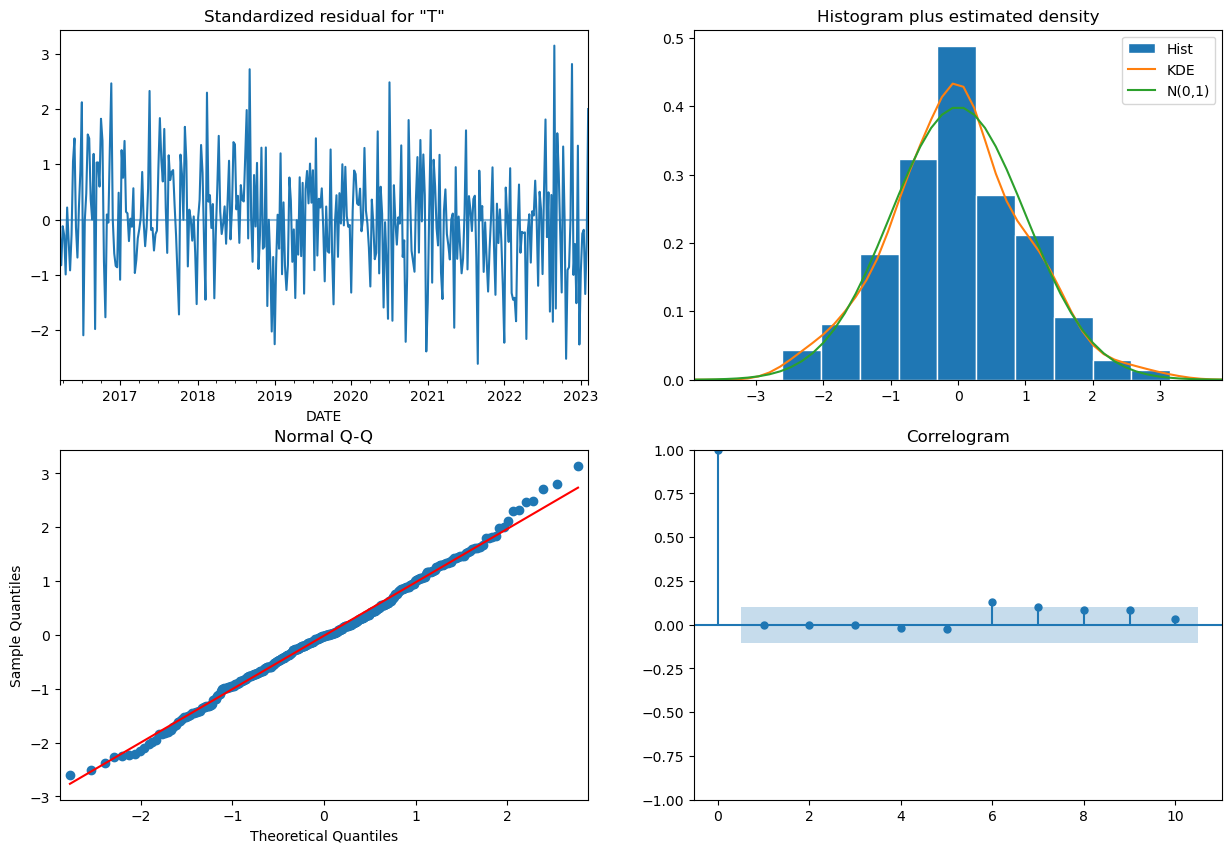

In [248]:
results.plot_diagnostics(figsize=(15, 10))
plt.show()

## South Island - Weekly 

In [235]:
weekly_lagged_south

,Total_TP,TP_lag1w,PRECTOTCORR,PRECIP_lag1w,PRECIP_lag2w,PRECIP_EWMA,GWETPROF,GWETPROF_lag1w,APIxGWETPROF,EVLAND,EVLAND_lag1w,EVLAND_EWMA,RH2M,RH2M_lag1w,T2M,T2M_lag1w
DATE,,,,,,,,,,,,,,,,
2015-03-22,2.950068e+08,3.243453e+08,264.80,156.42,767.35,488.289700,0.474921,0.480000,231.898854,165.01,228.78,224.290200,80.292381,77.127698,8.037778,12.604048
2015-03-29,2.870318e+08,2.950068e+08,367.40,264.80,156.42,452.022790,0.482063,0.474921,217.903685,154.86,165.01,203.461140,83.572698,80.292381,11.639524,8.037778
2015-04-05,2.590456e+08,2.870318e+08,189.24,367.40,264.80,373.187953,0.490952,0.482063,183.217514,177.98,154.86,195.816798,79.877222,83.572698,11.092937,11.639524
2015-04-12,2.441813e+08,2.590456e+08,470.76,189.24,367.40,402.459567,0.502540,0.490952,202.251903,166.54,177.98,187.033759,83.569683,79.877222,9.989206,11.092937
2015-04-19,2.735290e+08,2.441813e+08,333.51,470.76,189.24,381.774697,0.521032,0.502540,198.916737,129.33,166.54,169.722631,85.104524,83.569683,4.725635,9.989206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-29,3.134675e+08,3.769670e+08,431.76,567.99,334.96,436.783276,0.568231,0.577619,248.193925,524.58,509.09,543.042882,78.089796,78.759660,14.621837,11.802789
2025-01-05,3.059220e+08,3.134675e+08,373.74,431.76,567.99,417.870293,0.555685,0.568231,232.204225,497.24,524.58,529.302017,76.967260,78.089796,11.257329,14.621837
2025-01-12,3.399780e+08,3.059220e+08,269.11,373.74,431.76,373.242205,0.535102,0.555685,199.722666,498.12,497.24,519.947412,72.961769,76.967260,12.327211,11.257329


In [237]:
south.head()

DATE
2015-03-22    2.950068e+08
2015-03-29    2.870318e+08
2015-04-05    2.590456e+08
2015-04-12    2.441813e+08
2015-04-19    2.735290e+08
Freq: W-SUN, Name: Total_TP, dtype: float64

In [239]:
south

DATE
2015-03-22    2.950068e+08
2015-03-29    2.870318e+08
2015-04-05    2.590456e+08
2015-04-12    2.441813e+08
2015-04-19    2.735290e+08
                  ...     
2024-12-29    3.134675e+08
2025-01-05    3.059220e+08
2025-01-12    3.399780e+08
2025-01-19    3.410497e+08
2025-01-26    3.227407e+08
Freq: W-SUN, Name: Total_TP, Length: 515, dtype: float64

In [241]:
# Repeat the same steps for South Island:
series_s = south
n_n = len(series_s)
split_n = int(n_n * 0.8)

train_n = series_s.iloc[:split_n]
test_n  = series_s.iloc[split_n:]

model_n = SARIMAX(
    train_n,
    order=(0, 0, 2),
    seasonal_order=(1, 0, 0, 52),
    enforce_stationarity=False,
    enforce_invertibility=False
)
res_n = model_n.fit(disp=False)
print(res_n.summary())

fc_n = res_n.get_forecast(steps=len(test_n))
pred_n = pd.Series(fc_n.predicted_mean.values, index=test_n.index)

mae_n  = mean_absolute_error(test_n, pred_n)
rmse_n = np.sqrt(mean_squared_error(test_n, pred_n))
mape_n = np.mean(np.abs((test_n - pred_n) / test_n)) * 100

# rmse = np.sqrt(mean_squared_error(target_test, forecast))
# mae = mean_absolute_error(target_test, forecast)
# epsilon = 1e-10  # small constant to avoid division by zero in MAPE
# mape = np.mean(np.abs((target_test - forecast) / (target_test + epsilon))) * 100

print("South Island SARIMA Hydro (0, 0, 2)x(1, 0, 0, 52) → MAE:", f"{mae_n:.2f}",
      "RMSE:", f"{rmse_n:.2f}", "MAPE:", f"{mape_n:.2f}%")

                                      SARIMAX Results                                      
Dep. Variable:                            Total_TP   No. Observations:                  412
Model:             SARIMAX(0, 0, 2)x(1, 0, [], 52)   Log Likelihood               -7405.906
Date:                             Thu, 05 Jun 2025   AIC                          14819.811
Time:                                     07:42:40   BIC                          14835.356
Sample:                                 03-22-2015   HQIC                         14825.992
                                      - 02-05-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.8017      3.810      0.210      0.833      -6.666       8.270
ma.L2          0.4476      

In [243]:
pred_n

DATE
2023-02-12    3.120306e+08
2023-02-19    3.091040e+08
2023-02-26    3.304843e+08
2023-03-05    3.202119e+08
2023-03-12    3.121345e+08
                  ...     
2024-12-29    2.971700e+08
2025-01-05    3.202603e+08
2025-01-12    3.191837e+08
2025-01-19    3.195681e+08
2025-01-26    2.885162e+08
Freq: W-SUN, Length: 103, dtype: float64

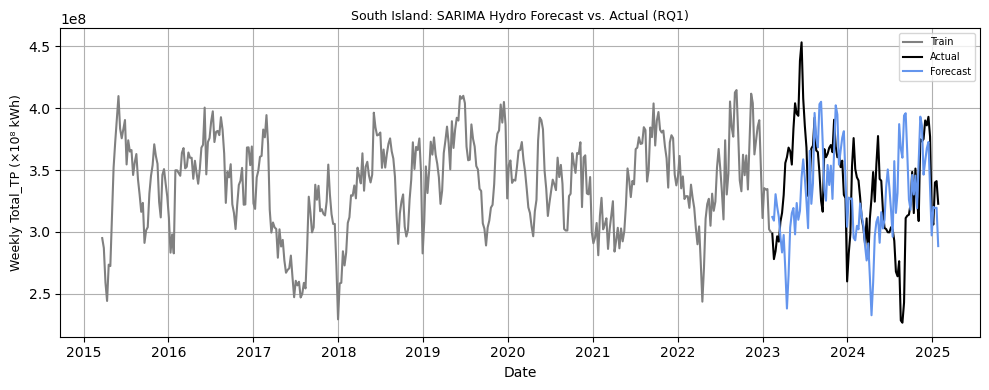

In [267]:
# Repeat a similar plot for North Island:
plt.figure(figsize=(10,4))
plt.plot(train_n.index, train_n, label="Train",   color="gray")
plt.plot(test_n.index,  test_n,  label="Actual",  color="black")
plt.plot(pred_n.index,  pred_n,  label="Forecast",color="cornflowerblue")
# plt.fill_between(
#     fc_n.conf_int().index,
#     fc_n.conf_int().iloc[:,0],
#     fc_n.conf_int().iloc[:,1],
#     color="lightblue", alpha=0.2
# )
plt.legend()
plt.title("South Island: SARIMA Hydro Forecast vs. Actual (RQ1)", fontsize=9)
plt.xlabel("Date")
plt.ylabel("Weekly Total_TP (×10⁸ kWh)" ,  fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.legend(loc="upper right", fontsize=7)
plt.show()

In [271]:
df_ann_hydro_south_wk

,Total_TP,TP_lag1w
DATE,,
2015-03-22,2.950068e+08,3.243453e+08
2015-03-29,2.870318e+08,2.950068e+08
2015-04-05,2.590456e+08,2.870318e+08
2015-04-12,2.441813e+08,2.590456e+08
2015-04-19,2.735290e+08,2.441813e+08
...,...,...
2024-12-29,3.134675e+08,3.769670e+08
2025-01-05,3.059220e+08,3.134675e+08
2025-01-12,3.399780e+08,3.059220e+08


In [245]:
# 2) Data prep (no randomness here, aside from ’shift’ which is deterministic)
df_ann_hydro_south_wk = weekly_lagged_south[['Total_TP','TP_lag1w']]

s_hydro_ann     = len(df_ann_hydro_south_wk)
split_ann = int(s_hydro_ann * 0.8)

train_s_ann = df_ann_hydro_south_wk.iloc[:split_ann]
test_s_ann  = df_ann_hydro_south_wk.iloc[split_ann:]

X_train_s_ann = train_s_ann[['TP_lag1w']].values
y_train_s_ann = train_s_ann['Total_TP'].values.reshape(-1,1)
X_test_s_ann  = test_s_ann[['TP_lag1w']].values
y_test_s_ann  = test_s_ann['Total_TP'].values.reshape(-1,1)

# 3) Scaling
scaler_X = MinMaxScaler()
X_train_s_s_ann = scaler_X.fit_transform(X_train_s_ann)
X_test_s_s_ann  = scaler_X.transform(X_test_s_ann)

scaler_y = MinMaxScaler()
y_train_s_s_ann = scaler_y.fit_transform(y_train_s_ann)
# (We hold off on transforming y_test because we want raw y_test for metrics.)

# 4) Build the ANN
model_ann_s = Sequential([
    Dense(16, activation='relu', input_shape=(1,)),
    Dense(8,  activation='relu'),
    Dense(1)
])
model_ann_s.compile(optimizer='adam', loss='mse')

# 5) Train the ANN (the shuffle order is now deterministic)
history_s = model_ann_s.fit(
    X_train_s_s_ann, y_train_s_s_ann,
    epochs=100,
    batch_size=16,
    validation_split=0.05,
    verbose=0
)

# 6) Predict & rescale
y_pred_s_s_ann = model_ann_s.predict(X_test_s_s_ann)
y_pred_s_ann   = scaler_y.inverse_transform(y_pred_s_s_ann).flatten()

# 7) Metrics on raw scale
mae_ann  = mean_absolute_error(y_test_s_ann.flatten(), y_pred_s_ann)
rmse_ann = np.sqrt(mean_squared_error(y_test_s_ann.flatten(), y_pred_s_ann))
mape_ann = np.mean(np.abs((y_test_s_ann.flatten() - y_pred_s_ann) / y_test_s_ann.flatten())) * 100

# print(f"Univariate ANN - MAE: {mae_ann:.2f}, RMSE: {rmse_ann:.2f}, MAPE: {mape_ann:.2f}%")
print("South Island ANN Hydro (without regressors) → MAE:", f"{mae_ann:.2f}",
      "RMSE:", f"{rmse_ann:.2f}", "MAPE:", f"{mape_ann:.2f}%")

C:\Users\nwn86\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002A42C360D60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
South Island ANN Hydro (without regressors) → MAE: 17298538.77 RMSE: 22725993.86 MAPE: 5.29%


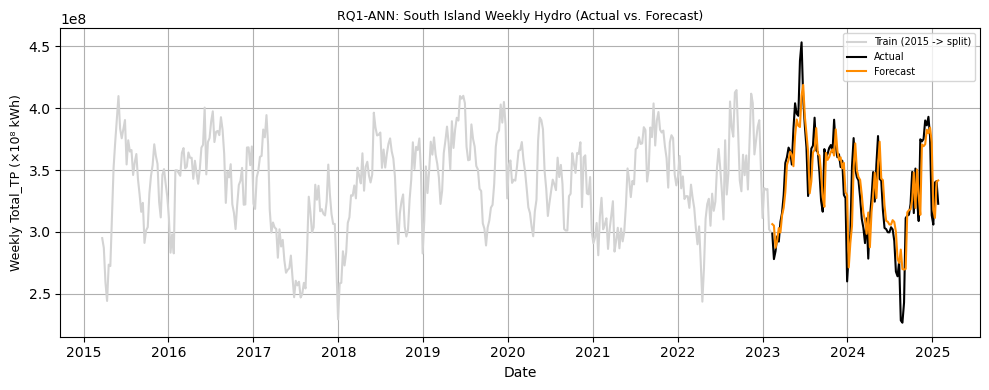

In [275]:
plt.figure(figsize=(10,4))
#plt.plot(train_s_ann.index,y_train_s_ann.flatten(),label="Train (2015 -> split)",color="lightgray")
plt.plot(test_s_ann.index, y_test_s_ann, label="Actual",color="black")
plt.plot(test_s_ann.index, y_pred_s_ann, label="Forecast",color="darkorange")
plt.title("RQ1‐ANN: South Island Weekly Hydro (Actual vs. Forecast)" , fontsize=9)
plt.xlabel("Date")
plt.ylabel("Weekly Total_TP (×10⁸ kWh)", fontsize=9)
plt.legend(loc="upper right", fontsize=7)
plt.grid(True)
plt.tight_layout()
plt.show()


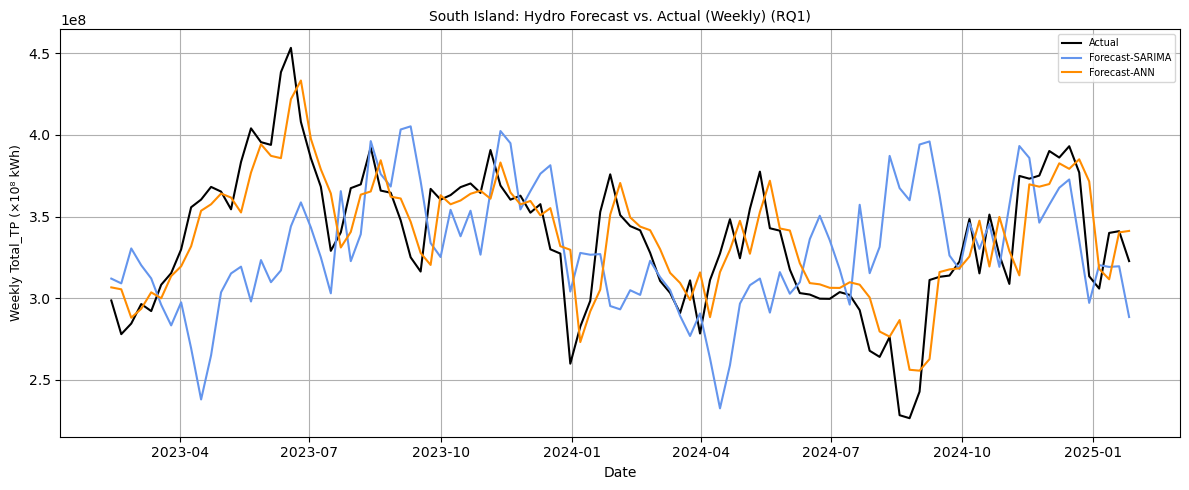

In [247]:
# Repeat a similar plot for North Island:
plt.figure(figsize=(12,5))
#plt.plot(train_n.index, train_n, label="Train",   color="gray")
plt.plot(test_n.index,  test_n,  label="Actual",  color="black")
plt.plot(pred_n.index,  pred_n,  label="Forecast-SARIMA",color="cornflowerblue")
plt.plot(test_s_ann.index, y_pred_s_ann, label="Forecast-ANN",color="darkorange")
# plt.fill_between(
#     fc_n.conf_int().index,
#     fc_n.conf_int().iloc[:,0],
#     fc_n.conf_int().iloc[:,1],
#     color="lightblue", alpha=0.2
# )
plt.legend()
plt.title("South Island: Hydro Forecast vs. Actual (Weekly) (RQ1)", fontsize=10)
plt.xlabel("Date")
plt.ylabel("Weekly Total_TP (×10⁸ kWh)" ,  fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.legend(loc="upper right", fontsize=7)
plt.show()

# plt.title("North Island: Hydro Forecast vs. Actual (Weekly) (RQ1)" , fontsize=10)

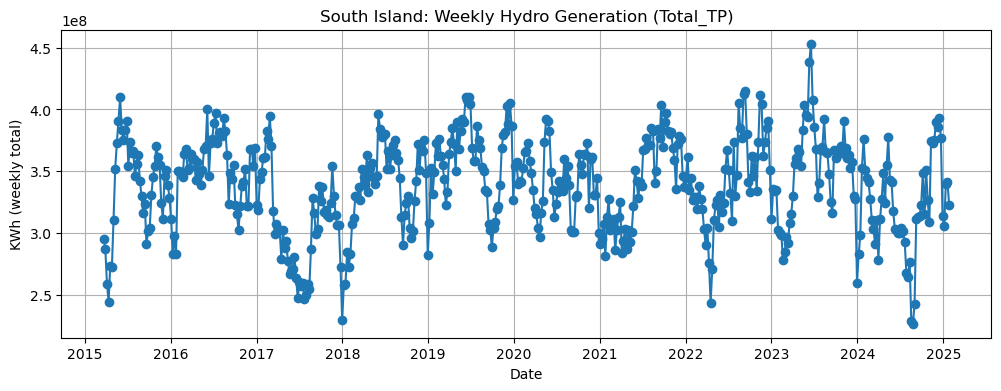

In [249]:
plt.figure(figsize=(12,4))
plt.plot(weekly_lagged_south['Total_TP'], marker='o', linestyle='-')
plt.title("South Island: Weekly Hydro Generation (Total_TP)")
plt.ylabel("KWh (weekly total)")
plt.xlabel("Date")
plt.grid(True)
plt.show()

In [251]:
# Find rows with zero Total_TP in South Island
zero_tp_south = weekly_lagged_south[weekly_lagged_south['Total_TP'] == 0]

# Get the unique dates
zero_dates = zero_tp_south.index.unique()

# Display the result
print("Dates with Total_TP = 0 in South Island:")
for date in zero_dates:
    print(date.strftime('%Y-%m-%d'))

Dates with Total_TP = 0 in South Island:


In [253]:
weekly_lagged_south.head(5)

,Total_TP,TP_lag1w,PRECTOTCORR,PRECIP_lag1w,PRECIP_lag2w,PRECIP_EWMA,GWETPROF,GWETPROF_lag1w,APIxGWETPROF,EVLAND,EVLAND_lag1w,EVLAND_EWMA,RH2M,RH2M_lag1w,T2M,T2M_lag1w
DATE,,,,,,,,,,,,,,,,
2015-03-22,2.950068e+08,3.243453e+08,264.80,156.42,767.35,488.289700,0.474921,0.480000,231.898854,165.01,228.78,224.290200,80.292381,77.127698,8.037778,12.604048
2015-03-29,2.870318e+08,2.950068e+08,367.40,264.80,156.42,452.022790,0.482063,0.474921,217.903685,154.86,165.01,203.461140,83.572698,80.292381,11.639524,8.037778
2015-04-05,2.590456e+08,2.870318e+08,189.24,367.40,264.80,373.187953,0.490952,0.482063,183.217514,177.98,154.86,195.816798,79.877222,83.572698,11.092937,11.639524
2015-04-12,2.441813e+08,2.590456e+08,470.76,189.24,367.40,402.459567,0.502540,0.490952,202.251903,166.54,177.98,187.033759,83.569683,79.877222,9.989206,11.092937
2015-04-19,2.735290e+08,2.441813e+08,333.51,470.76,189.24,381.774697,0.521032,0.502540,198.916737,129.33,166.54,169.722631,85.104524,83.569683,4.725635,9.989206


In [255]:
# Split the weekly data into 80% training and 20% testing sets
n = len(weekly_lagged_south)
train_size = int(n * 0.8)
train_weekly = weekly_lagged_south.iloc[:train_size]
test_weekly = weekly_lagged_south.iloc[train_size:]

In [257]:
print("Weekly Train set:", train_weekly.index.min(), "to", train_weekly.index.max() , " Records count : ",len(train_weekly) )
print("Weekly Test set:", test_weekly.index.min(), "to", test_weekly.index.max(), " Records count : ",len(test_weekly) )

Weekly Train set: 2015-03-22 00:00:00 to 2023-02-05 00:00:00  Records count :  412
Weekly Test set: 2023-02-12 00:00:00 to 2025-01-26 00:00:00  Records count :  103


In [259]:
# Define the target variable (original Total_TP) and exogenous variables
# target_train_log = train_weekly['Total_TP_log']
# target_test_log = test_weekly['Total_TP_log']

target_train = train_weekly['Total_TP']
target_test = test_weekly['Total_TP']


In [261]:
#['Total_TP', 'PRECTOTCORR', 'EVLAND', 'RH2M', 'GWETPROF', 'T2M', 'PRECIP_lag1w', 'PRECIP_lag2w', 'API_weekly']
#befoe exog_cols_wk = ['RH2M', 'GWETPROF', 'PRECIP_lag1w', 'PRECIP_lag2w', 'API_weekly']
#exog_cols_wk = ['TP_lag1w','APIxGWETPROF','PRECIP_EWMA','GWETPROF_lag1w']
#exog_cols_wk = ['APIxGWETPROF','PRECIP_EWMA','GWETPROF_lag1w']
#exog_cols = ['WS50M']
#'TP_lag1w','APIxGWETPROF','PRECIP_EWMA','GWETPROF_lag1w'

exog_cols_wk = ['TP_lag1w', 'APIxGWETPROF', 'PRECIP_EWMA']

In [263]:
exog_train = train_weekly[exog_cols_wk]
exog_test = test_weekly[exog_cols_wk]

In [265]:
# Fit SARIMAX on the original (non-log) target data
#1. South Island SARIMA(1, 0, 0)x(0, 0, 1, 52) → MAE: 75226135.36 RMSE: 84557781.81 MAPE: 21.44%
#2. South Island SARIMA(1, 0, 1)x(0, 0, 1, 52) → MAE: 68755956.11 RMSE: 77859468.87 MAPE: 19.54%
model = SARIMAX(target_train,
                exog=exog_train,
                order=(0, 0, 2),
                seasonal_order=(1, 0, 0, 52),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit(disp=False)
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                            Total_TP   No. Observations:                  412
Model:             SARIMAX(0, 0, 2)x(1, 0, [], 52)   Log Likelihood               -6548.960
Date:                             Thu, 05 Jun 2025   AIC                          13111.920
Time:                                     07:45:19   BIC                          13139.123
Sample:                                 03-22-2015   HQIC                         13122.736
                                      - 02-05-2023                                         
Covariance Type:                               opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
TP_lag1w         0.9502      0.009    107.737      0.000       0.933       0.967
APIxGWETPROF  -468.46

In [267]:
# Forecast on the test set - non log
n_steps = len(test_weekly)
forecast = results.get_forecast(steps=n_steps, exog=exog_test).predicted_mean

In [269]:
# Compute performance metrics - non log
rmse = np.sqrt(mean_squared_error(target_test, forecast))
mae = mean_absolute_error(target_test, forecast)
epsilon = 1e-10  # small constant to avoid division by zero in MAPE
mape = np.mean(np.abs((target_test - forecast) / (target_test + epsilon))) * 100

# print("\nForecast Performance Metrics (Without Log Transformation):")
# print(f"RMSE: {rmse:.2f}")
# print(f"MAE: {mae:.2f}")
# print(f"Adjusted MAPE: {mape:.2f}%")
print("South Island SARIMA Hydro (0, 0, 2)x(1, 0, 0, 52) → MAE:", f"{mae:.2f}",
      "RMSE:", f"{rmse:.2f}", "MAPE:", f"{mape:.2f}%")

South Island SARIMA Hydro (0, 0, 2)x(1, 0, 0, 52) → MAE: 16453845.96 RMSE: 22079011.63 MAPE: 4.97%


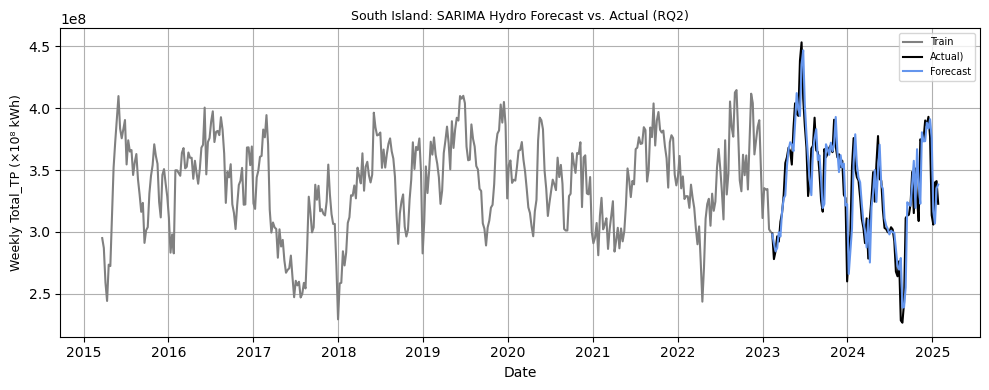

In [303]:
# # Plot Actual vs. Forecast
# plt.figure(figsize=(14, 7))
# plt.plot(train_weekly.index, target_train, label='Train', color='blue')
# plt.plot(test_weekly.index, target_test, label='Test', color='green')
# plt.plot(test_weekly.index, forecast, label='Forecast', color='red', linestyle='--')
# plt.xlabel("Date")
# plt.ylabel("Total_TP")
# plt.title("Weekly SARIMAX Forecast-North Island (Without Log Transformation)")
# plt.legend()
# plt.tight_layout()
# plt.show()

# Repeat a similar plot for North Island:
plt.figure(figsize=(10,4))
plt.plot(train_weekly.index, target_train, label="Train",   color="gray")
plt.plot(test_weekly.index,  target_test,  label="Actual)",  color="black")
plt.plot(forecast.index,  forecast,  label="Forecast",color="cornflowerblue")
# plt.fill_between(
#     fc_n.conf_int().index,
#     fc_n.conf_int().iloc[:,0],
#     fc_n.conf_int().iloc[:,1],
#     color="lightblue", alpha=0.2
# )
plt.legend()
plt.title("South Island: SARIMA Hydro Forecast vs. Actual (RQ2)", fontsize=9)
plt.xlabel("Date")
plt.ylabel("Weekly Total_TP (×10⁸ kWh)" ,  fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.legend(loc="upper right", fontsize=7)
plt.show()

# plt.legend()
# plt.title("South Island: SARIMA Hydro Forecast vs. Actual (RQ1)", fontsize=9)
# plt.xlabel("Date")
# plt.ylabel("Weekly Total_TP (×10⁸ kWh)" ,  fontsize=9)
# plt.grid(True)
# plt.tight_layout()
# plt.legend(loc="upper right", fontsize=7)
# plt.show()

In [275]:
#factors = ['TP_lag1w','APIxGWETPROF','PRECIP_EWMA','GWETPROF_lag1w']

factors_s_ann2 = ['TP_lag1w', 'APIxGWETPROF']

# 2) Split via slicing
n = len(weekly_lagged_south)
split_idx = int(n * 0.8)

train_df_s_ann2 = weekly_lagged_south.iloc[:split_idx]
test_df_s_ann2 = weekly_lagged_south.iloc[split_idx:]

# 3) Extract raw X and y for train/test
X_train_raw_s_ann2 = train_df_s_ann2[factors_s_ann2].values  # (n_samples, n_features)
X_test_raw_s_ann2 = test_df_s_ann2[factors_s_ann2].values
y_train_raw_s_ann2 = train_df_s_ann2['Total_TP'].values.reshape(-1, 1)
y_test_raw_s_ann2 = test_df_s_ann2['Total_TP'].values.reshape(-1, 1) # (n_samples, 1)

# 4) Scale
x_scaler_s_ann2  = StandardScaler().fit(X_train_raw_s_ann2)
y_scaler_s_ann2  = StandardScaler().fit(y_train_raw_s_ann2)

X_train_s_ann2  = x_scaler.transform(X_train_raw_s_ann2)
X_test_s_ann2   = x_scaler.transform(X_test_raw_s_ann2)
y_train_s_ann2  = y_scaler.transform(y_train_raw_s_ann2)
y_test_s_ann2   = y_scaler.transform(y_test_raw_s_ann2)

# 5) Sanity‐check shapes
print(X_train_s_ann2.shape, y_train_s_ann2.shape)
print(X_test_s_ann2.shape,  y_test_s_ann2.shape)

# optimizer with clipping & lower LR
opt = tf.keras.optimizers.Adam(learning_rate=5e-4, clipnorm=1.0)

#   ANN Model  
model = Sequential([
    Dense(64, input_shape=(X_train_s_ann2.shape[1],)),  # start with 64 neurons
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),

    Dense(32),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),

    Dense(16),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),

    Dense(1)  # linear output for regression
])

#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse")


model.compile(
    optimizer=opt,
    loss=Huber(delta=0.5),
    metrics=[tf.keras.metrics.MeanAbsolutePercentageError(name='mape')]
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

history = model.fit(
    X_train_s_ann2, y_train_s_ann2,
    validation_split=0.10,  # 10% of training for validation
    epochs=200,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# 1) Predict & inverse‑scale
y_pred_s_s_ann2 = model.predict(X_test_s_ann2)
y_pred_s_ann2 = y_scaler.inverse_transform(y_pred_s_s_ann2).ravel()
y_true_s_ann2 = y_scaler.inverse_transform(y_test_s_ann2).ravel()

# 2) Metrics
mae  = mean_absolute_error(y_true_s_ann2, y_pred_s_ann2)
#rmse = mean_squared_error(y_true, y_pred, squared=False)
rmse = root_mean_squared_error(y_true_s_ann2, y_pred_s_ann2)
mape = mean_absolute_percentage_error(y_true_s_ann2, y_pred_s_ann2) * 100
# print("\nRQ2‐ANN Performance - Hydro (South Island):")
# print(f"MAE : {mae:,.2f}")
# print(f"RMSE: {rmse:,.2f}")
# print(f"MAPE: {mape:.2f}%")

print("South Island ANN Hydro  → MAE:", f"{mae:.2f}",
      "RMSE:", f"{rmse:.2f}", "MAPE:", f"{mape:.2f}%")

(412, 2) (412, 1)
(103, 2) (103, 1)
Epoch 1/200


C:\Users\nwn86\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\nwn86\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.9282 - mape: 105.2382 - val_loss: 3.0536 - val_mape: 102.0989 - learning_rate: 5.0000e-04
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8930 - mape: 103.9637 - val_loss: 2.9990 - val_mape: 100.3447 - learning_rate: 5.0000e-04
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.8608 - mape: 102.9937 - val_loss: 2.9599 - val_mape: 99.1185 - learning_rate: 5.0000e-04
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.8169 - mape: 101.4319 - val_loss: 2.9188 - val_mape: 97.8253 - learning_rate: 5.0000e-04
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.7843 - mape: 100.2987 - val_loss: 2.8666 - val_mape: 96.1957 - learning_rate: 5.0000e-04
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.7529 - mape: 98.9911 - val_loss: 2.8374 - val_mape: 95.2823 - learning_rate: 5.0000e-04
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7075 - mape: 97.4874 - val_loss: 2.8018 - val_map

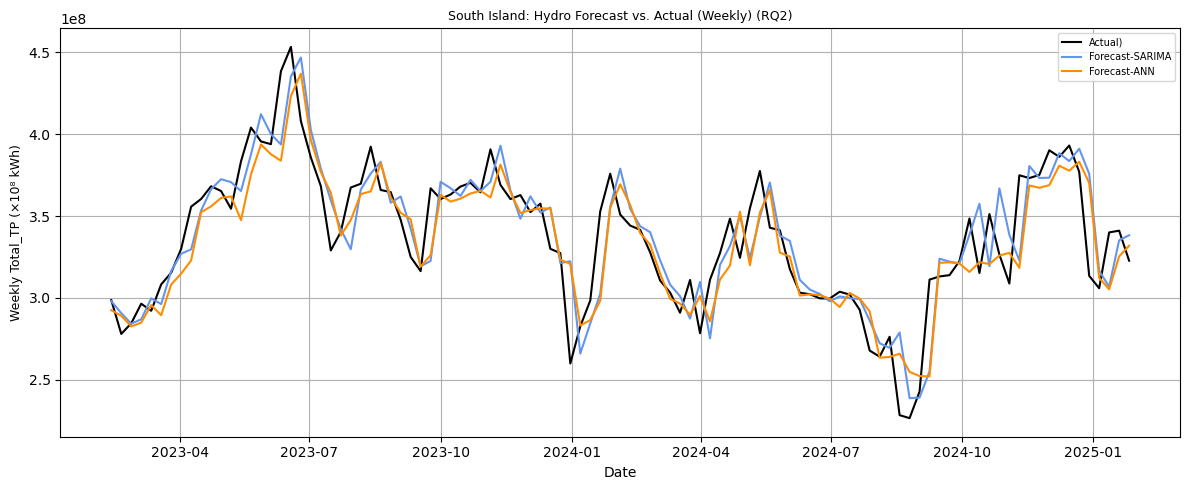

In [277]:
# Repeat a similar plot for North Island:
plt.figure(figsize=(12,5))
#plt.plot(train_weekly.index, target_train, label="Train",   color="gray")
plt.plot(test_weekly.index,  target_test,  label="Actual)",  color="black")
plt.plot(forecast.index,  forecast,  label="Forecast-SARIMA",color="cornflowerblue")
plt.plot(test_df_s_ann2.index,y_pred_s_ann2,label="Forecast-ANN",color="darkorange")
plt.legend()
plt.title("South Island: Hydro Forecast vs. Actual (Weekly) (RQ2)", fontsize=9)
plt.xlabel("Date")
plt.ylabel("Weekly Total_TP (×10⁸ kWh)" ,  fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.legend(loc="upper right", fontsize=7)
plt.show()

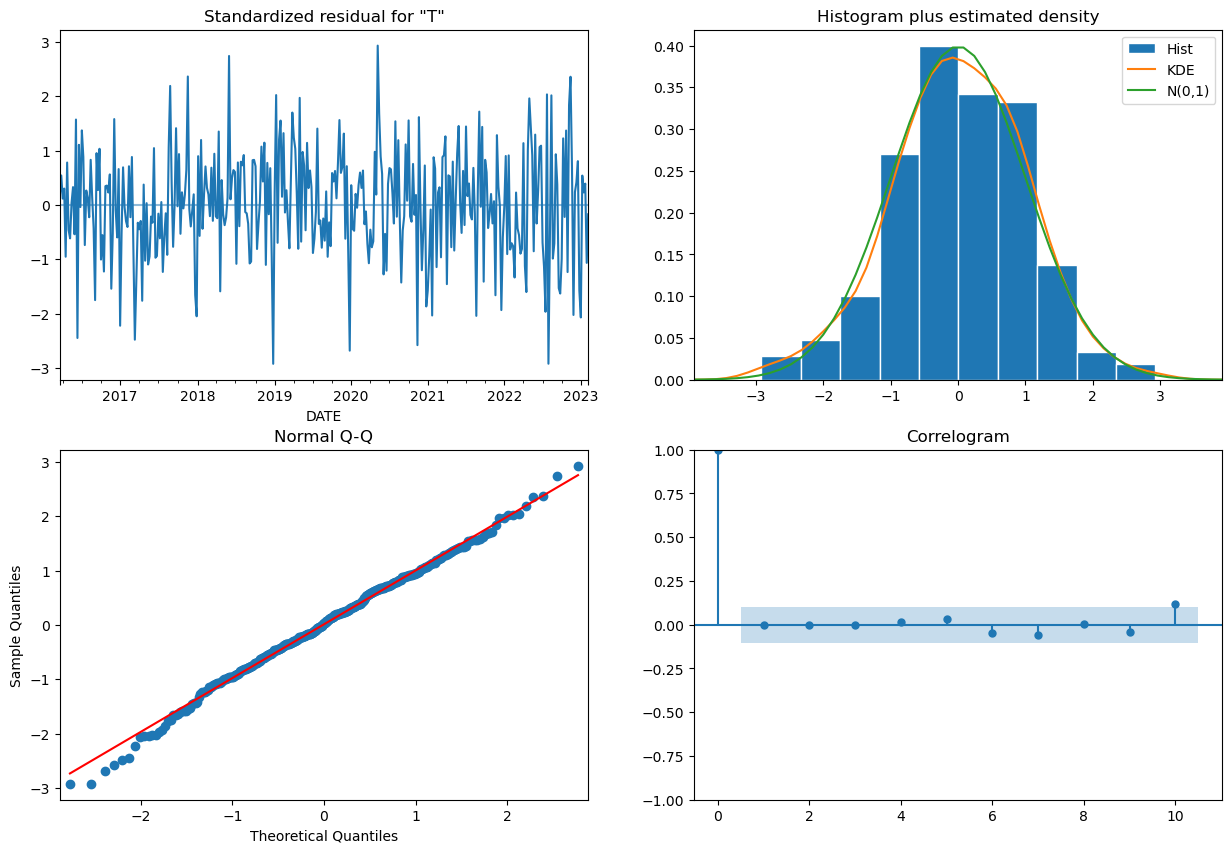

In [305]:
results.plot_diagnostics(figsize=(15, 10))
plt.show()

If a zero actually means no generation (e.g., turbine was off), you might not want to interpolate—but if it’s a data artifact or gap, this is valid.